In [4]:
dataset_name = "W14_comb"
df_list = [
#            "BES_Panel",
#            "BES_reduced_with_na",
#            "BESnumeric"
#            "BES_reduced",
#            "BESnumeric"
          ]

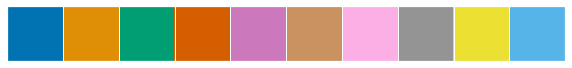

In [5]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re
sns.set()
sns.palplot(sns.color_palette("colorblind"))
from IPython.display import display, display_html, HTML
plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
from utility import *
import gaussian_kde

import warnings
warnings.filterwarnings('ignore')


In [6]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()



In [7]:
global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

In [8]:
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_values"+".csv")

In [9]:
global best_weight_series
def weighted_mean(series):
    return (series*best_weight_series.loc[series.index]).sum()/(best_weight_series.loc[series.index]).sum()


In [10]:
BES_census_data = pd.read_stata( BES_small_data_files + "BES-2017-General-Election-results-file-v1.0.dta" )
BES_census_data["ConstituencyName"].loc[628]="Ynys Mon"
print("BES_census_data", BES_census_data.shape )

BES_census_data (632, 308)


In [8]:
# BES_census_data.columns[BES_census_data.dtypes=='int16']
# 'RejectedVote17', 'RejectedVote15'
# pano = constId

c11_vars = [x for x in BES_census_data.columns[BES_census_data.dtypes=='float'] if "c11" in x]
nonc11vars = [x for x in BES_census_data.columns[BES_census_data.dtypes=='float'] if "c11" not in x]

num_non_perc_vars = ['RejectedVote17', 'RejectedVote15']
num_non_perc_vars.extend(list(BES_census_data.columns[BES_census_data.dtypes=='int32']))
num_non_perc_vars.append('c11PopulationDensity')

percentage_vars = c11_vars
percentage_vars.remove('c11PopulationDensity')

percentage_vars.extend( list(BES_census_data[nonc11vars].columns[ BES_census_data[nonc11vars].max()<=100 ]) )

num_non_perc_vars.extend( list(BES_census_data[nonc11vars].columns[ BES_census_data[nonc11vars].max()>100 ]) )

id_vars = ["pano","ONSConstID","ConstituencyName"]
name_vars = [x for x in BES_census_data.columns if re.search("PPC(17|15)",x)]

BES_census_data[["SeatChange1517","SeatChange1015"]] = BES_census_data[["SeatChange1517","SeatChange1015"]].replace(" ",np.nan).astype('category')

categorical_vars = list( BES_census_data.columns[BES_census_data.dtypes=='category'] )
categorical_vars.extend(["SeatChange1517","SeatChange1015"])


df = pd.concat([ pd.get_dummies(BES_census_data[categorical_vars]),
                 BES_census_data[ percentage_vars+num_non_perc_vars ] ], axis=1).astype('float')

non_pol_vars = [x for x in df.columns if "c11" in x]
non_pol_vars.extend([x for x in df.columns if "Country" in x])
non_pol_vars.extend([x for x in df.columns if "Region" in x])
non_pol_vars.extend([x for x in df.columns if "ConstituencyType" in x])
# non_pol_vars

In [19]:
reg_vot["%"].apply(lambda x: x.replace("%","")).astype('int')

0      16
1      13
2      12
3      11
4      11
       ..
518    -3
519    -3
520    -3
521    -5
522    -6
Name: %, Length: 523, dtype: int32

In [44]:
fn = BES_data_folder+"parliamentary constituency data"+os.sep+"Chaminda Jayanetti's registered voters"+os.sep+"GE19 registered voters published - Sheet1.csv"
reg_vot = pd.read_csv(fn)
reg_vot.index = reg_vot["Constituency"]
df["reg_voters_perc_change"] = reg_vot.loc[BES_census_data["ConstituencyName"]]["%"].apply(lambda x: x.replace("%","") if pd.notnull(x) else np.nan).astype('float').values

In [35]:
df = df.apply(lambda x: x.fillna(x.mean()))

In [46]:
%%time

pattern = "reg_voters_perc_change"
name = "reg_voters_perc_change"
corr_type = "spearman"
df_corr,corr_type = make_corr_summary(df, name, corr_type, min_sample_size=26)
display_corr(df_corr, name, corr_type, text_wrap_length=50, top_num = 15)

Top 15 positive (spearman) correlations for reg_voters_perc_change r p N 
 
 c11BornOtherPre2004EU 
 0.29 
 0.00 
 446 
 
 
 c11Degree 
 0.26 
 0.00 
 446 
 
 
 c11QualLevel4 
 0.25 
 0.00 
 446 
 
 
 c11BornOtherEU 
 0.25 
 0.00 
 446 
 
 
 c11Population 
 0.25 
 0.00 
 446 
 
 
 remainHanretty 
 0.25 
 0.00 
 446 
 
 
 c11Jewish 
 0.25 
 0.00 
 446 
 
 
 c11EthnicityWhiteOther 
 0.25 
 0.00 
 446 
 
 
 c11HousePrivate 
 0.24 
 0.00 
 446 
 
 
 c11HouseholdAllStudents 
 0.24 
 0.00 
 446 
 
 
 c11EconomicallyActiveStudent 
 0.24 
 0.00 
 446 
 
 
 c11IndustryProfessional 
 0.23 
 0.00 
 446 
 
 
 c11HousePrivateLandlord 
 0.23 
 0.00 
 446 
 
 
 UKIP1517 
 0.22 
 0.00 
 446 
 
 
 c11EthnicityChinese 
 0.22 
 0.00 
 446 
 
 Top 15 negative (spearman) correlations for reg_voters_perc_change r p N 
 
 c11HouseholdCohabitNodependents 
 -0.29 
 0.00 
 446 
 
 
 c11NSSECSemiRoutine 
 -0.28 
 0.00 
 446 
 
 
 c11NSSECLowerSupervisor 
 -0.27 
 0.00 
 446 
 
 
 c11HouseholdCohabitDependents 
 -0.26 
 0.00 
 446 
 
 
 c11HouseholdMarriedNondependents 
 -0.26 
 0.00 
 446 
 
 
 c11HealthFair 
 -0.25 
 0.00 
 446 
 
 
 leaveHanretty 
 -0.25 
 0.00 
 446 
 
 
 UKIP1015 
 -0.24 
 0.00 
 446 
 
 
 c11IndustryConstruction 
 -0.24 
 0.00 
 446 
 
 
 UKIP15 
 -0.23 
 0.00 
 446 
 
 
 c11CarsOne 
 -0.23 
 0.00 
 446 
 
 
 c11QualNone 
 -0.23 
 0.00 
 446 
 
 
 c11QualApprentice 
 -0.22 
 0.00 
 446 
 
 
 c11BornUK 
 -0.22 
 0.00 
 446 
 
 
 c11IndustryManufacturing 
 -0.22 
 0.00 
 446

Wall time: 2.22 s


In [47]:
import shap
import xgboost as xgb
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

In [73]:
# df = df.loc[:,~df.columns.duplicated()]
BES_cens = df.copy()

In [109]:
Treatment = "xgboost_census_reg_voters"
var_stub = "reg_voters_perc_change"
global var_list
var_list = ["reg_voters_perc_change"]

var_stub_list = [var_stub, "reg_voters_perc_change"]

# ImmigDiff = get_diff(["likeCorbyn"])#.notnull().sum()

# var_list = ImmigDiff.columns

# ["profile_education_age","workingStatus","profile_work_stat",]

optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
    return 1
#(BES_Panel["profile_eurefvote"]=="Leave the EU")



def create_train(drop_other_waves):
    keep_list = BES_cens.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return BES_cens[keep_list][mask]


def create_target(target_var):
    
    return BES_cens[target_var]

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.01,
 n_estimators= 1800,
 max_depth=10,
 min_child_weight=6,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.7,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=0.01,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)

# alg = XGBRegressor(**best_params)

In [92]:
best_params_with_more_estimators = best_params.copy()

In [94]:
best_params_with_more_estimators["n_estimators"] = 1800

In [59]:
global var_list
def xgboost_run(title, subdir=None, min_features=30, dependence_plots=False , output_folder=".."+os.sep+"Output"+os.sep,Treatment="default"):
    # for target_var,base_var in zip(var_list,base_list):
    treatment_subfolder = create_subdir(output_folder,Treatment)

    for target_var in var_list:
        if sample_wts:
            wave_no = get_wave_no( target_var )
            weight_var = num_to_weight[wave_no]    
            print( target_var, wave_no )

        target = create_target(target_var)
        mask   = target.notnull()
        if optional_mask & sample_wts:
            mask = mask&optional_mask_fn(wave_no)
        else:
            mask = mask&optional_mask_fn()
        target = target[mask]

        if sum(mask) < minimum_sample:
            continue

        train = create_train(drop_other_waves)

        if subdir is None:
            output_subfolder = create_subdir(treatment_subfolder,target_var)
        else:
            output_subfolder = create_subdir(treatment_subfolder,subdir)

        if sample_wts:
            sample_weights = weights[weight_var][mask]
            print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
            sample_weights = sample_weights.fillna(sample_weights.median())
        else:
            sample_weights = None
    #         get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, sample_weights )
    #         # fit to full dataset at non-overfitting level
    #         alg.fit(train, target, verbose = True, sample_weight = sample_weights)        
    #     else:

        get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                                  sample_weights=sample_weights )
        # fit to full dataset at non-overfitting level
        alg.fit(train, target, verbose = True, sample_weight = sample_weights)


    #################

        explainer = shap.TreeExplainer(alg)
        shap_values = explainer.shap_values(train)
        
#         shap_values = shap.TreeExplainer(alg).shap_values(train);

        shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
        if shap_problem:
            print("hit problem!")
            shap_values = shap.TreeExplainer(alg).shap_values(train, approximate=True);

        shap_outputs(shap_values, train, target_var, output_subfolder, threshold = .1,
                     min_features = min_features, title=title,
                     dependence_plots=dependence_plots)
        
    return (explainer, shap_values)




[0]	validation_0-rmse:2.53482
Will train until validation_0-rmse hasn't improved in 180.0 rounds.
[1]	validation_0-rmse:2.52673
[2]	validation_0-rmse:2.51773
[3]	validation_0-rmse:2.5083
[4]	validation_0-rmse:2.49852
[5]	validation_0-rmse:2.48837
[6]	validation_0-rmse:2.48199
[7]	validation_0-rmse:2.47776
[8]	validation_0-rmse:2.47099
[9]	validation_0-rmse:2.46281
[10]	validation_0-rmse:2.45618
[11]	validation_0-rmse:2.44944
[12]	validation_0-rmse:2.44327
[13]	validation_0-rmse:2.43693
[14]	validation_0-rmse:2.43332
[15]	validation_0-rmse:2.42797
[16]	validation_0-rmse:2.42147
[17]	validation_0-rmse:2.41407
[18]	validation_0-rmse:2.40843
[19]	validation_0-rmse:2.40128
[20]	validation_0-rmse:2.393
[21]	validation_0-rmse:2.38767
[22]	validation_0-rmse:2.38411
[23]	validation_0-rmse:2.38154
[24]	validation_0-rmse:2.37601
[25]	validation_0-rmse:2.37088
[26]	validation_0-rmse:2.36584
[27]	validation_0-rmse:2.35891
[28]	validation_0-rmse:2.35484
[29]	validation_0-rmse:2.35097
[30]	validation

[258]	validation_0-rmse:2.05199
[259]	validation_0-rmse:2.05249
[260]	validation_0-rmse:2.05078
[261]	validation_0-rmse:2.04972
[262]	validation_0-rmse:2.04967
[263]	validation_0-rmse:2.04984
[264]	validation_0-rmse:2.04981
[265]	validation_0-rmse:2.0503
[266]	validation_0-rmse:2.05089
[267]	validation_0-rmse:2.04997
[268]	validation_0-rmse:2.04924
[269]	validation_0-rmse:2.0492
[270]	validation_0-rmse:2.05013
[271]	validation_0-rmse:2.04987
[272]	validation_0-rmse:2.05008
[273]	validation_0-rmse:2.04929
[274]	validation_0-rmse:2.04908
[275]	validation_0-rmse:2.04935
[276]	validation_0-rmse:2.04966
[277]	validation_0-rmse:2.04958
[278]	validation_0-rmse:2.04896
[279]	validation_0-rmse:2.04911
[280]	validation_0-rmse:2.04878
[281]	validation_0-rmse:2.04836
[282]	validation_0-rmse:2.04864
[283]	validation_0-rmse:2.04956
[284]	validation_0-rmse:2.04987
[285]	validation_0-rmse:2.05042
[286]	validation_0-rmse:2.05084
[287]	validation_0-rmse:2.051
[288]	validation_0-rmse:2.0502
[289]	validat

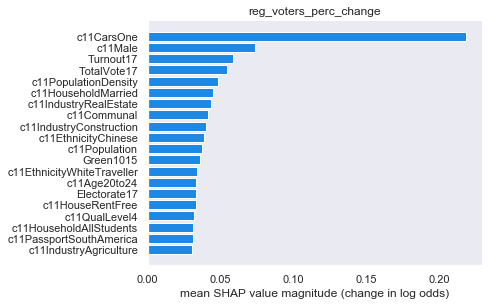

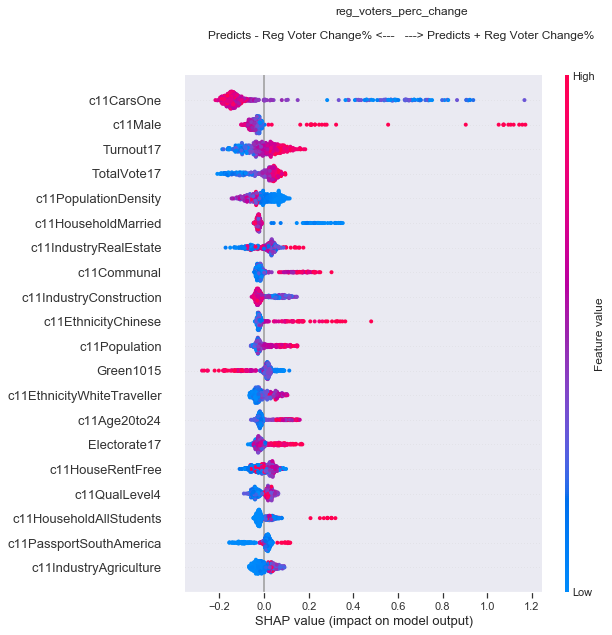

(<shap.explainers.tree.TreeExplainer at 0x2be82cc0>,
 array([[ 0.        ,  0.        ,  0.        , ..., -0.00170013,
          0.00010623, -0.00453561],
        [ 0.        ,  0.        ,  0.        , ..., -0.01189939,
         -0.003836  ,  0.00110129],
        [ 0.        ,  0.        ,  0.        , ...,  0.00587189,
         -0.00454466, -0.01393522],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -0.00112828,
         -0.00215816, -0.00593977],
        [ 0.        ,  0.        ,  0.        , ..., -0.01033415,
          0.02563895, -0.01005878],
        [ 0.        ,  0.        ,  0.        , ..., -0.02089306,
         -0.00111882, -0.04383478]], dtype=float32))

In [110]:
colname = "reg_voters_perc_change"
# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
mask = BES_cens[colname].notnull()
xgboost_run(subdir=colname,min_features = min(BES_cens.shape[1]-1,20),
           title = colname+"\n\nPredicts - Reg Voter Change% <---   ---> Predicts + Reg Voter Change%")

In [ ]:
# basic MSE: 4.30, MAE: 1.53, EV: 0.19, R2: 0.19
# optimised: MSE: 4.30, MAE: 1.53, EV: 0.20, R2: 0.19

In [83]:

target = create_target("reg_voters_perc_change")[mask]
train = create_train(drop_other_waves)[mask]

In [100]:
### xgboost_tuner
# https://github.com/cwerner87/xgboost-tuner

from xgboost_tuner.tuner import tune_xgb_params

# train = X.values
# label = rounded_targets

# metric_sklearn = ‘neg_mean_squared_error’ or 'remse'
# estimator_cls = xgb.XGBClassifier, xgb.XGBRegressor


# Tune the parameters incrementally and limit the range for colsample_bytree and subsample
best_params, history = tune_xgb_params(
    cv_folds = 3,
    label = target,
    metric_sklearn = 'neg_mean_squared_error',
    metric_xgb = "rmse",
    n_jobs = 4,
    objective = 'reg:linear',
    random_state = seed,
    strategy = 'randomized',
    train = train,
#     init_colsample_bylevel=.85,
    init_colsample_bytree = 0.7,
    init_gamma = 0.0,
    init_max_depth = 10,
    init_min_child_weight  = 6,
    init_subsample = 0.6,
    learning_rates = [0.03,.04,.05,.06],
)

# alg = XGBRegressor(
#  learning_rate =0.05,
#  n_estimators= 1800,
#  max_depth=10,
#  min_child_weight=6,
#  gamma=0,
#  subsample=0.6,
#  colsample_bytree=0.7,
#  colsample_bylevel=.85,
#  objective= objective,
#  scale_pos_weight=1.0,
#  reg_alpha=0.01,
#  reg_lambda=1,
#  njobs=3,
#  seed=seed**2)

[0]	train-rmse:2.54008+0.135194	test-rmse:2.55325+0.269261
[1]	train-rmse:2.46733+0.13101	test-rmse:2.51575+0.256904
[2]	train-rmse:2.40566+0.125274	test-rmse:2.49403+0.251611
[3]	train-rmse:2.33549+0.126849	test-rmse:2.45529+0.243378
[4]	train-rmse:2.2722+0.118635	test-rmse:2.43047+0.242967
[5]	train-rmse:2.20167+0.118559	test-rmse:2.40957+0.228058
[6]	train-rmse:2.14082+0.106758	test-rmse:2.38443+0.22537
[7]	train-rmse:2.08268+0.0993983	test-rmse:2.36625+0.217453
[8]	train-rmse:2.02724+0.0931695	test-rmse:2.34644+0.221505
[9]	train-rmse:1.96818+0.0937452	test-rmse:2.33552+0.210884
[10]	train-rmse:1.91996+0.0883118	test-rmse:2.32053+0.216257
[11]	train-rmse:1.87491+0.0847506	test-rmse:2.31675+0.207018
[12]	train-rmse:1.82594+0.0761279	test-rmse:2.30649+0.205668
[13]	train-rmse:1.78195+0.071056	test-rmse:2.2908+0.192924
[14]	train-rmse:1.73135+0.0658056	test-rmse:2.28105+0.190766
[15]	train-rmse:1.68525+0.0640206	test-rmse:2.27922+0.188337
[16]	train-rmse:1.64925+0.065898	test-rmse:2.2

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    5.5s finished


[0]	train-rmse:2.56562+0.136323	test-rmse:2.57847+0.276602
[1]	train-rmse:2.51435+0.139173	test-rmse:2.54423+0.265739
[2]	train-rmse:2.46921+0.128828	test-rmse:2.51929+0.267949
[3]	train-rmse:2.4211+0.133946	test-rmse:2.48983+0.261569
[4]	train-rmse:2.37749+0.123292	test-rmse:2.46809+0.26347
[5]	train-rmse:2.32968+0.123034	test-rmse:2.44499+0.252583
[6]	train-rmse:2.29444+0.121079	test-rmse:2.42817+0.247494
[7]	train-rmse:2.25515+0.114965	test-rmse:2.41221+0.241682
[8]	train-rmse:2.21997+0.114294	test-rmse:2.39481+0.239537
[9]	train-rmse:2.1817+0.111415	test-rmse:2.37895+0.240123
[10]	train-rmse:2.14731+0.106785	test-rmse:2.36339+0.239406
[11]	train-rmse:2.11327+0.0985781	test-rmse:2.35551+0.237489
[12]	train-rmse:2.08083+0.091236	test-rmse:2.34335+0.23306
[13]	train-rmse:2.04706+0.0900285	test-rmse:2.33334+0.230584
[14]	train-rmse:2.01373+0.0855269	test-rmse:2.33206+0.227681
[15]	train-rmse:1.97887+0.0866251	test-rmse:2.31929+0.217148
[16]	train-rmse:1.95082+0.0835387	test-rmse:2.3137

[42]	train-rmse:1.58942+0.0511267	test-rmse:2.23038+0.194889
[43]	train-rmse:1.57865+0.0499801	test-rmse:2.23018+0.193156
[44]	train-rmse:1.56609+0.0486505	test-rmse:2.23002+0.193378
[45]	train-rmse:1.55374+0.0490978	test-rmse:2.22986+0.191643
[46]	train-rmse:1.54139+0.0519871	test-rmse:2.22934+0.189556
[47]	train-rmse:1.5293+0.051703	test-rmse:2.22697+0.187692
[48]	train-rmse:1.51849+0.0533046	test-rmse:2.22518+0.183171
[49]	train-rmse:1.50772+0.0541981	test-rmse:2.22379+0.18231
[50]	train-rmse:1.49906+0.0532234	test-rmse:2.22529+0.182277
[51]	train-rmse:1.48846+0.0514952	test-rmse:2.22544+0.183442
[52]	train-rmse:1.47905+0.0520061	test-rmse:2.22727+0.183352
[53]	train-rmse:1.4674+0.05375	test-rmse:2.22908+0.183654
[54]	train-rmse:1.45503+0.0515175	test-rmse:2.23139+0.181609
[55]	train-rmse:1.44398+0.0507257	test-rmse:2.23103+0.179274
[56]	train-rmse:1.43504+0.0486369	test-rmse:2.2312+0.178784
[57]	train-rmse:1.42715+0.0466423	test-rmse:2.23082+0.176911
[58]	train-rmse:1.41661+0.04508

[79]	train-rmse:1.40168+0.0403782	test-rmse:2.21854+0.176607
[80]	train-rmse:1.39513+0.0403319	test-rmse:2.21823+0.176541
[81]	train-rmse:1.38824+0.0412339	test-rmse:2.21745+0.176829
[82]	train-rmse:1.38257+0.0414933	test-rmse:2.21808+0.175129
[83]	train-rmse:1.3768+0.0417211	test-rmse:2.21983+0.174517
[84]	train-rmse:1.37013+0.0406067	test-rmse:2.22012+0.173274
[85]	train-rmse:1.36307+0.0405943	test-rmse:2.21908+0.173748
[86]	train-rmse:1.35573+0.0391182	test-rmse:2.21857+0.17521
[87]	train-rmse:1.34693+0.0379278	test-rmse:2.21634+0.174
[88]	train-rmse:1.34027+0.0385582	test-rmse:2.21686+0.173297
[89]	train-rmse:1.33277+0.0386239	test-rmse:2.21557+0.172207
[90]	train-rmse:1.32614+0.0400246	test-rmse:2.21869+0.172114
[91]	train-rmse:1.31981+0.0392892	test-rmse:2.2207+0.171137
[92]	train-rmse:1.31315+0.040167	test-rmse:2.22155+0.17174
[93]	train-rmse:1.30596+0.040176	test-rmse:2.22298+0.171751
[94]	train-rmse:1.29937+0.0408665	test-rmse:2.22351+0.171431
[95]	train-rmse:1.29219+0.0414407

In [101]:
best_params

{'colsample_bytree': 0.5817379933661244,
 'gamma': 0.8133540490880262,
 'learning_rate': 0.06,
 'max_depth': 9,
 'min_child_weight': 9,
 'nthread': 4,
 'objective': 'reg:linear',
 'scale_pos_weight': 1,
 'subsample': 0.5228650037758216,
 'random_state': 27,
 'n_estimators': 27,
 'reg_alpha': 3.5033775431214447,
 'reg_lambda': 0.8105108398296856}

In [68]:
len(df.columns)

377

In [69]:
len(set(df.columns))

360

In [72]:
l = list(df.columns)
set([x for x in l if l.count(x) > 1])

set()

In [71]:
#####################

In [405]:
fn = BES_data_folder+"parliamentary constituency data"+os.sep+"All parliamentary constituency data - processed to be flat.xlsx"

In [357]:
stub = "DISEASES_"
df = pd.read_excel(fn,sheet_name = "Constituency Diseases")
drop_list = ['Name', 'Region']
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+"Code")
#'Atrial Fibrilliation', 'Asthma', 'Cancer', 'Coronary Heart Disease', 'Chronic Kidney Disease', 'COPD', 'Cardiovascular Disease (Primary Prevention)', 'Dementia', 'Depression', 'Diabetes', 'Epilepsy', 'Heart Failure', 'High Blood Pressure', 'Learning Disabilities', 'Serious Mental Illness', 'Obesity', 'Osteoporisis', 'Peripheral Arterial Disease', 'Palliative Care', 'Rheumatoid Arthritis', 'Stroke & Transient Ischaemic Attack'
BES_census_data.shape

(632, 330)

In [358]:
stub = "EDUCATION_"
df = pd.read_excel(fn,sheet_name = "Constituency Education")
drop_list = ["Year",'Eng. KS4 Avg Att. 8 ',"Constituency Name","Region ID","Region Name"]
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+"Constituency ID")
# 'Cons. A*-C %', 'England A*-C %', 'Cons, AAB %', 'Region AAB %', 'England AAB %', 'Cons. KS4 Avg Att. 8', 'Cons. % Outstanding (Secondary)', 'Reg. % Outstanding (Secondary)', 'Eng. % Outstanding (Secondary)', 'Cons. % Good (Secondary)', 'Reg. % Good (Secondary)', 'Eng. % Good (Secondary)', 'Cons. % In need of Improvement (Secondary)', 'Reg. % In need of Improvement (Secondary)', 'Eng. % In need of Improvement (Secondary)', 'Cons. % Inadequate (Secondary)', 'Reg. % Inadequate (Secondary)', 'Eng. % Inadequate (Secondary)', 'Cons. % Outstanding (Primary)', 'Reg. % Outstanding (Primary)', 'Eng. % Outstanding (Primary)', 'Cons. % Good (Primary)', 'Reg. % Good (Primary)', 'Eng. % Good (Primary)', 'Cons. % In need of Improvement (Primary)', 'Reg. % In need of Improvement (Primary)', 'Eng. % In need of Improvement (Primary)', 'Cons. % Inadequate (Primary)', 'Reg. % Inadequate (Primary)', 'Eng. % Inadequate (Primary)', 'Cons. Average Progress 8'
BES_census_data.shape

(632, 362)

In [328]:
stub = "UNEMPLOYMENT_"
df = pd.read_excel(fn,sheet_name = "Constituency Unemployment Rates")
drop_list = ['ConstituencyName', 'RegionID', 'RegionName', 'CountryID', 'CountryName', 'DateThisUpdate', 'DateOfDataset', 'UnempRegionNumber', 'UnempRegionRate', 'UnempCountryNumber', 'UnempCountryRate']
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+"ONSConstID")
# UnempConstNumber	UnempConstRate

In [359]:
stub = "BUSINESS_"
df = pd.read_excel(fn,sheet_name = "Constituency Business Numbers")
drop_list = ['ConstituencyName', 'RegionID', 'RegionName', 'CountryID',
       'CountryName', 'DateThisUpdate', 'DateOfDataset']
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+"ONSConstID")
# 'BusConstNumber', 'BusConstNetChange', 'BusConst%change', 'BusRegionNumber', 'BusRegionNetChange', 'BusRegion%change', 'BusCountryNumber', 'BusCountryNetChange', 'BusCountry%change'
BES_census_data.shape

(632, 366)

In [360]:
stub = "ELECTORATE_"
df = pd.read_excel(fn,sheet_name = "Constituency Electorate")
drop_list = ['ConstituencyName', 'type', 'year', 'UK_average_PC']
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+"ONSConstID")
# 'PC_Electors', 'LG_Electors', 'LG_Attainers', 'EER18CD', 'EER18NM', 'PC_Attainers',  'regional_average_PC',
BES_census_data.shape

(632, 374)

In [398]:
stub = "TRAFFIC_"
df = pd.read_excel(fn,sheet_name = "Constituency Traffic Accidents")
drop_list = [ 'year']
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ConstituencyName",right_on=stub+"pcon16nm")
#  'casualties', 'accidents'
BES_census_data.shape

(632, 564)

In [397]:
BES_census_data.drop([x for x in BES_census_data.columns if "TRAFFIC" in x],axis=1,inplace=True)

In [399]:
BES_census_data[[x for x in BES_census_data.columns if "TRAFFIC" in x]]

TRAFFIC_pcon16nm  TRAFFIC_casualties  TRAFFIC_accidents
0                             Aberavon               114.0               90.0
1                            Aberconwy               121.0               93.0
2                       Aberdeen North                80.0               73.0
3                       Aberdeen South                51.0               46.0
4    West Aberdeenshire and Kincardine               106.0               71.0
..                                 ...                 ...                ...
627                             Yeovil               252.0              176.0
628                           Ynys Mon               107.0               76.0
629                       York Central               235.0              206.0
630                         York Outer               234.0              175.0
631                     East Yorkshire               315.0              231.0

[632 rows x 3 columns]

In [362]:
stub = "BROADBAND_"
df = pd.read_excel(fn,sheet_name = "Constituency Broadband")
drop_list = ['pcon-nm', 'Name',  'ConstituencySpeedMap',
       'ConstituencyConnectivityMap']
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+"pcon-code")
# 'Speed', 'Superfast', 'UnableDecent', 'Under2', 'Under10', 'Over30',
BES_census_data.shape

(632, 384)

In [363]:
stub = "WAGES_"
df = pd.read_excel(fn,sheet_name = "Constituency Wages")
drop_list = ['ConstituencyName', 'RegionID', 'RegionName', 'CountryID',
       'CountryName', 'DateOfThisUpdate', 'DateOfDataset', 'WageMedianRegion', 'WageMedianCountry']
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+"ONSConstID")
# WageMedianConst
BES_census_data.shape

(632, 386)

In [364]:
# stub = "HOUSETENURE_"
# df = pd.read_excel(fn,sheet_name = "Constituency House Tenure")
# drop_list = ['ConstituencyName', 'RegionID', 'RegionName', 'CountryID',
#        'CountryName', 'Date','CON%All', 'Reg%All', 'CTRYLevelAll', 'CTRY%All',
#        'CTRYLevelOwn', 'CTRYLevelOwn_out', 'CTRYLevelOwn_mort',
#        'CTRYLevelShare', 'CTRYLevelSoc_r', 'CTRYLevelSoc_r_LA',
#        'CTRYLevelSoc_r_Other', 'CTRYLevelPrivate_rent',
#        'CTRYLevelPrivate_r_land', 'CTRYLevelPrivate_r_Oth',
#        'CTRYLevelRent_free', 'REGLevelAll', 'REGLevelOwn', 'REG%Own', 'CTRY%Own', 'REGLevelOwn_out', 'REG%Own_out', 'CTRY%Own_out', 'REGLevelOwn_mort', 'REG%Own_mort', 'CTRY%Own_mort', 'REGLevelShare', 'REG%Share', 'CTRY%Share', 'REGLevelSoc_r', 'REG%Soc_r', 'CTRY%Soc_r', 'REGLevelSoc_r_LA', 'REG%Soc_r_LA', 'CTRY%Soc_r_LA', 'REGLevelSoc_r_Other', 'REG%Soc_r_Other', 'CTRY%Soc_r_Other', 'REGLevelPrivate_rent', 'REG%Private_rent', 'CTRY%Private_rent', 'REGLevelPrivate_r_land', 'REG%Private_r_land', 'CTRY%Private_r_land', 'REGLevelPrivate_r_Oth', 'REG%Private_r_Oth', 'CTRY%Private_r_Oth', 'REGLevelRent_free', 'REG%Rent_free', 'CTRY%Rent_free']
# df.drop(drop_list,axis=1,inplace=True)
# df.columns = stub+df.columns
# BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+"ONSConstID")
# # 'CONLevelAll', 'CONLevelOwn', 'CON%Own',
# #        'CONLevelOwn_out', 'CON%Own_out', 'CONLevelOwn_mort', 'CON%Own_mort',
# #        'CONLevelShare', 'CON%Share', 'CONLevelSoc_r', 'CON%Soc_r',
# #        'CONLevelSoc_r_LA', 'CON%Soc_r_LA', 'CONLevelSoc_r_Other',
# #        'CON%Soc_r_Other', 'CONLevelPrivate_rent', 'CON%Private_rent',
# #        'CONLevelPrivate_r_land', 'CON%Private_r_land', 'CONLevelPrivate_r_Oth',
# #        'CON%Private_r_Oth', 'CONLevelRent_free', 'CON%Rent_free'
# BES_census_data.shape

(632, 410)

In [365]:
stub = "HOUSEPRICES_"
df = pd.read_excel(fn,sheet_name = "Constituency House Prices")
drop_list = ['ConstituencyName', 'RegionID', 'RegionName', 'CountryID',
       'CountryName', 'DateThisUpdate', 'DateOfDataset',
       'HouseConstMedianPrice', 'HouseRegionMedianPrice',
       'HouseCountryMedianPrice',
       'RegionPercentChangeOneYr', 'CountryPercentChangeOneYr',
       'RegionPercentChangeFiveYr',
       'CountryPercentChangeFiveYr',  'RegWage',
       'RegRatio', 'CountryWage', 'CountryRatio']
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+"ONSConstID")
# 'HouseConstMedianPrice', 'ConstPercentChangeOneYr', 'ConstPercentChangeFiveYr','ConstWage', 'ConstRatio',
BES_census_data.shape

(632, 415)

In [366]:
stub = "INSOLVENCIES_"
df = pd.read_excel(fn,sheet_name = "Total Ind Insolvencies 2014")
drop_list =['Parliamentary Constituencies', ]
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+"Codes")
# 'Number of new cases', 'Rate per 10,000 adult population'
BES_census_data.shape

(632, 418)

In [367]:
stub = "IVAS_"
df = pd.read_excel(fn,sheet_name = "Ind Voluntary Arrangements 2014")
drop_list =[ 'Parliamentary Constituencies', ]
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+"Codes")
# 'Number of new cases',  'Rate per 10,000 adult population'
BES_census_data.shape

(632, 421)

In [368]:
stub = "DEBTRELIEFORDERS_"
df = pd.read_excel(fn,sheet_name = "Debt Relief Orders 2014")
drop_list =[ 'Parliamentary Constituencies', ]
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+"Codes")
# 'Number of new cases',  'Rate per 10,000 adult population'
BES_census_data.shape

(632, 424)

In [369]:
stub = "BANKRUPTCY_"
df = pd.read_excel(fn,sheet_name = "Bankruptcy Orders 2014")
drop_list =[ 'Parliamentary Constituencies', ]
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+"Codes")
# 'Number of new cases',  'Rate per 10,000 adult population'
BES_census_data.shape

(632, 427)

In [370]:
stub = "FUELPOVERTY_"
df = pd.read_excel(fn,sheet_name = "Fuel Poverty 2017")
drop_list = ['Parliamentary Constituency',  'Region' ]
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+'Parliamentary Constituency Code')
# 'Estimated number of households',
#        'Estimated number of fuel poor households',
#        'Proportion of households fuel poor (%)'
BES_census_data.shape

(632, 431)

In [371]:
stub = "HELPTOWORK_"
df = pd.read_excel(fn,sheet_name = "DWP-Help To Work 2014-2017")
# drop_list = ['Parliamentary Constituency',  'Region' ]
# df.drop(drop_list,axis=1,inplace=True)
df.columns = ["ConstituencyName", 'Number joining Daily Work Search',
       'Numbers joining Mandatory Intervention Regime',
       'Numbers joining Community Work Placement',
       'Number starting a work placement through Community Work Placement']
# df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ConstituencyName",right_on=stub+'ConstituencyName')
# 'Number joining Daily Work Search',
#        'Numbers joining Mandatory Intervention Regime',
#        'Numbers joining Community Work Placement',
#        'Number starting a work placement through Community Work Placement'
BES_census_data.shape

(632, 436)

In [372]:
stub = "HOUSEHOLDECOS_"
df = pd.read_excel(fn,sheet_name = "Households ECO measures 2015")
drop_list =['Parliamentary Constituency Name',
       ]
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+"Parliamentary Constituency Code")
# 'Total number of households in receipt of ECO measures',
#        'Households with at least one usual resident1,2',
#        'Households in receipt of ECO measures per 1,000 households'
BES_census_data.shape

(632, 440)

In [458]:
stub = "ECOOBLIGATIONS_"
df = pd.read_excel(fn,sheet_name = "ECO measures by ECO obl. 2015")
drop_list =['Parliamentary Constituency Name',"Unnamed: 6"]
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+"Parliamentary Constituency Code")
# 
#        'Carbon Saving Target (CSO)', 'Carbon Savings Community (CSCO)',
#        'Affordable Warmth (HHCRO)', 'Total number of ECO measures delivered',
#        'Unnamed: 6', 'Households with at least one usual resident1,2',
#        'ECO measures per 1,000 households
BES_census_data.shape

(632, 588)

In [454]:
stub = "FEEDINCAPACITY_"
df = pd.read_excel(fn,sheet_name = "Feed in- cum installed cap-2019")
drop_list =['Parliamentary Constituency Name',]
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+"Parliamentary Constituency Code")

#        'Photovoltaics Domestic', 'Photovoltaics Total', 'Wind Domestic',
#        'Wind Total', 'Hydro Domestic', 'Hydro Total',
#        'Anaerobic Digestion Domestic', 'Anaerobic Digestion Total',
#        'MicroCHP Domestic', 'MicroCHP Total', 'Total Domestic',
#        'Total Non-Domestic', 'Total'
BES_census_data.shape

(632, 581)

In [455]:
stub = "FEEDINNUMBERS_"
df = pd.read_excel(fn,sheet_name = "Feed in- cum number inst-2019")
drop_list =['Parliamentary Constituency Name',]
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+"Parliamentary Constituency Code")

#        'Photovoltaics Domestic', 'Photovoltaics Total', 'Wind Domestic',
#        'Wind Total', 'Hydro Domestic', 'Hydro Total',
#        'Anaerobic Digestion Domestic', 'Anaerobic Digestion Total',
#        'MicroCHP Domestic', 'MicroCHP Total', 'Total Domestic',
#        'Total Non-Domestic', 'Total'
BES_census_data.shape

(632, 595)

In [376]:
stub = "BENEFITEXPENDITURE_"
df = pd.read_excel(fn,sheet_name = "Benefit Expenditure 2018-2019")
drop_list =['Incapacity Benefit']
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ConstituencyName",right_on=stub+"Constituency Name")

# 'Total', 'Attendance Allowance',
#        'Bereavement Benefit/Widow's Benefit', 'Carer's Allowance',
#        'Disability Living Allowance', 'of which children',
#        'of which working age', 'of which pensioners',
#        'Employment And Support Allowance', 'Housing Benefit',
#        'Income Support', 'of which Lone Parent',
#        'of which Carer', 'of which Others', 'Jobseeker's Allowance',
#        'Pension Credit', 'Personal Independence Payment',
#        'Severe Disablement Allowance', 'of which working age.1',
#        'of which pensioners.1', 'State Pension', 'Winter Fuel Payments'
BES_census_data.shape

(632, 499)

In [377]:
stub = "INCOMEANDTAX_"
df = pd.read_excel(fn,sheet_name = "Income and tax 2016-2017")
drop_list =[ 'Unnamed: 17', 'Unnamed: 18',      'Unnamed: 19']
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ConstituencyName",right_on=stub+"Parliamentary Constituency")

#        'Self employment income No. of individuals',
#        'Self employment income Mean', 'Self employment income Median',
#        'Employment income No. of individuals', 'Employment income Mean',
#        'Employment income Median', 'Pension income No. of individuals',
#        'Pension income Mean', 'Pension income Median',
#        'Total income No. of individuals', 'Total income Mean',
#        'Total income Median', 'Total tax No. of individuals', 'Total tax Mean',
#        'Total tax Median', 'Total tax Amount',
BES_census_data.shape

(632, 516)

In [378]:
stub = "CHILDTAXCREDITS_"
df = pd.read_excel(fn,sheet_name = "Child Tax Credits")
drop_list =[ 'ConstituencyName', ]
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+"Code")

# 'Children in IS/JSA families Couple',
#        'Children in IS/JSA families Lone parent',
#        'Children in families receiving WTC and CTC, and income <60% median income Couple',
#        'Children in families receiving WTC and CTC, and income <60% median income Lone parent',
#        'Children in families receiving CTC only, and income <60% median income Couple',
#        'Children in families receiving CTC only, and income <60% median income Lone parent',
#        'Children in families in receipt of CTC (<60% median income) or IS/JSA  Couple',
#        'Children in families in receipt of CTC (<60% median income) or IS/JSA  Lone parent',
#        '% of Children in low-income families All Families'
BES_census_data.shape

(632, 526)

In [379]:
stub = "FOCALDATAMRP_DEC_"
df = pd.read_excel(fn,sheet_name = "Focaldata MRP 2019")
drop_list =['ConstituencyName', 'NUTS1 Region', 'Winning party' ]
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+'Westminster Constituency Code')

# 'Conservative', 'Labour', 'Liberal Democrats', 'SNP', 'Other', 'Green',
#        'Brexit Party', 'Plaid Cymru'
BES_census_data.shape

(632, 535)

In [380]:
stub = "YOUGOVMRP_DEC_"
df = pd.read_excel(fn,sheet_name = "YouGov MRP December 2019")
drop_list =['constituency' ]
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+'code')

# 'Conservative', 'Labour', 'Liberal Democrats', 'SNP', 'Other', 'Green',
#        'Brexit Party', 'Plaid Cymru'
BES_census_data.shape

(632, 544)

In [382]:
stub = "YOUGOVMRP_NOV_"
df = pd.read_excel(fn,sheet_name = "YouGov MRP November 2019")
drop_list =['constituency']
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+'code')

# 'Con', 'Lab', 'LD', 'Brexit', 'Green', 'SNP',      'PC', 'Other'
BES_census_data.shape

(632, 553)

In [383]:
stub = "CHAM_REG_VOTERS_"
df = pd.read_excel(fn,sheet_name = "GE19 registered voters publ")
df.columns = [str(x) for x in df.columns]
drop_list =[   'Constituency',           'LA',           '2017',
                     '2017 maj',
                'F-H',      '2017 MP']
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+'GSS Code')

# '2019', 'Change',            '%',
BES_census_data.shape

(632, 557)

In [410]:
# stub = "ELECTORSANDATTAINERS_"
# df = pd.read_excel(fn,sheet_name = "Electors&Attainers2018")
# drop_list =['Parliamentary constituency',]
# df.drop(drop_list,axis=1,inplace=True)
# df.columns = stub+df.columns
# BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+'Codes')

# #        'Total electors (includes attainers) 1st December 2018',
# #        'Attainers 1st December 2018'

In [419]:
BES_census_data.shape

(632, 566)

In [428]:
stub = "LABOURMARKET_"
df = pd.read_excel(fn,sheet_name = "Local labour market indicators")
drop_list =['ConstituencyName']
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+'ONSConstID')

#        'Population 16-64  (000s)',
#        'Labour supply Employment Total  16+ (000s)',
#        'Labour supply Employment 16-64 Rate (%)',
#        'Labour supply Unemployment Total 16+ (000s)',
#        'Labour supply Unemployment Rate (%)',
#        'Labour supply Economic inactivity Total 16-64 (000s)',
#        'Labour supply Economic inactivity 16-64 Rate (%)',
#        'Labour supply Claimant Count Level',
#        'Labour supply Claimant Count Proportion (%)',
#        'Labour demand Jobs Total (000s)',
#        'Labour demand Jobs Jobs Density 16-64 (ratio)',
#        'Labour demand Earnings Resident (£)',
#        'Labour demand Earnings Workplace (£)'

In [437]:
stub = "REFERRALS_"
df = pd.read_excel(fn,sheet_name = "DWPReferrals2011-2017")
drop_list =['ConstituencyName', ]
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+'Code')

#        'Number of people who have been referred',
#        'Number of referrals that could of acheieved a job outcome',
#        'Number of referrals that did achieve a job outcome',
#        'Percentage of the referrals that could achieve a job outcome that did (%)'

In [442]:
stub = "STAMPDUTY_"
df = pd.read_excel(fn,sheet_name = "StampDutyLandTaxGTE40k2018-2019")
drop_list =['ConstituencyName', ]
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+'ONSConstID')

#        'Residential Number of transactions',
#        'Residential Estimated Property Value', 'Residential Receipts',
#        'Non-residential Number of transactions',
#        'Non-residential  Estimated Property Value', 'Non-residential Receipts',
#        'All property Number of transactions',
#        'All property Estimated Property Value', 'All property Receipts'

In [585]:
BES_census_data.shape

(632, 521)

In [641]:
fn = BES_data_folder+"parliamentary constituency data"+os.sep+"Lots of aggregated parliamentary data.csv"
BES_census_data.to_csv(fn)


In [401]:
BES_census_data.drop(["ECOOBLIGATIONS_Unnamed: 6"],axis=1,inplace=True)

In [509]:
BES_census_data.dtypes.value_counts()

float64     433
int64        65
object       18
category     14
int32        10
category      7
int16         3
category      2
category      1
category      1
category      1
category      1
dtype: int64

In [506]:
vars_need_cleaning = [ 'HOUSEPRICES_ConstPercentChangeOneYr',
       'HOUSEPRICES_ConstPercentChangeFiveYr', 'HOUSEPRICES_ConstWage',
       'HOUSEPRICES_ConstRatio',
       'INCOMEANDTAX_Self employment income No. of individuals',
       'INCOMEANDTAX_Self employment income Mean',
       'INCOMEANDTAX_Self employment income Median',
       'LABOURMARKET_Labour supply Unemployment Total 16+ (000s)',
       'LABOURMARKET_Labour supply Unemployment Rate (%)',
       'LABOURMARKET_Labour demand Earnings Workplace (£)']


BES_census_data[ vars_need_cleaning ] = BES_census_data[ vars_need_cleaning ].replace("-",np.nan).replace("#",np.nan).replace("..",np.nan).replace("~",np.nan)


In [492]:
excess_region_variables = ["ELECTORATE_EER18CD","ELECTORATE_EER18NM"]
BES_census_data.drop(excess_region_variables, axis=1, inplace=True)   

In [457]:
BES_census_data.drop([x for x in BES_census_data.columns if "ECOOBLIGATIONS" in x],axis=1,inplace=True)

In [483]:
codes = BES_census_data["ONSConstID"].values
code_match_columns = BES_census_data.apply(lambda x: sum(x==codes))
key_columns = list( code_match_columns[code_match_columns>10].index )
key_columns.remove("ONSConstID")

BES_census_data.drop(key_columns, axis=1, inplace=True)


In [488]:
excess_const_name_variables = ["TRAFFIC_pcon16nm","INCOMEANDTAX_Parliamentary Constituency","BENEFITEXPENDITURE_Constituency Name","HELPTOWORK_ConstituencyName"]
BES_census_data.drop(excess_const_name_variables, axis=1, inplace=True)

In [521]:
zero_variance_columns = BES_census_data.var().index[ BES_census_data.var()==0 ]
BES_census_data.drop(zero_variance_columns, axis=1, inplace=True)

In [550]:
corr = BES_census_data.corr()
corr=corr-np.diag(np.diag(corr))

In [554]:
corr.max(axis=1).sort_values().tail(50)

GreenVote17                                                                                           0.996874
SNP1015                                                                                               0.996874
HOUSETENURE_CONLevelPrivate_rent                                                                      0.997869
HOUSETENURE_CONLevelPrivate_r_land                                                                    0.997869
YOUGOVMRP_DEC_SNP                                                                                     0.998157
YOUGOVMRP_NOV_SNP                                                                                     0.998157
FEEDINNUMBERS_Total.5                                                                                 0.998562
FEEDINNUMBERS_Total                                                                                   0.998956
FEEDINNUMBERS_Domestic                                                                                0.998959
F

In [570]:
BES_census_data.drop([x for x in BES_census_data.columns if "ELECTORSANDATTAINERS_" in x],axis=1,inplace=True)
BES_census_data.drop([x for x in BES_census_data.columns if "HOUSETENURE_" in x],axis=1,inplace=True)

In [582]:
# perfect correlation with other variables *not semiexplicit in definition*
BES_census_data.drop(corr_df.loc[[72, 116, 60, 147],"var1"].values,axis=1,inplace=True)


In [571]:
corr_mat = BES_census_data.corr()

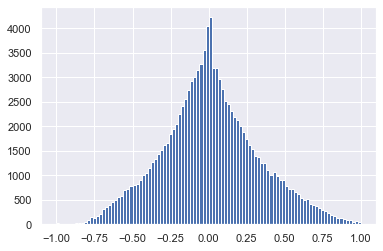

In [572]:
# %%time
## 5 minutes!
## 8h 41min 19s on W10_comb panel!

# data = BES_numeric
# corr_mat = BES_numeric.corr()

# create lower triangle - diag mask
col_vars = len( corr_mat )
df = pd.DataFrame( np.arange(col_vars*col_vars).reshape(col_vars,col_vars) )
mask = np.ones(df.shape,dtype='bool')
mask[np.triu_indices(len(df))] = False
corr_mat.mask(~mask).stack().hist(bins=100);

In [573]:
# build a data frame of pairs of highly corr/anti-corr variables
# score on correlation, %non-missing values for each
# Building the high_corr_list is still **manual** (not much reason to automate)


corr_df = pd.DataFrame(columns = ["var1","var2","corr","var1%","var2%","min var%"])

id_num = 0

# min_filled_out = 0.02
min_filled_out = 0.02

thresh = .05
x = ( ( corr_mat>(1-thresh) ) &mask ).values.nonzero()

for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    c = BES_census_data[a].notnull().mean()
    d = BES_census_data[b].notnull().mean()
    mincd = min(c,d)
    if mincd > min_filled_out:
        corr_df.loc[id_num] = [ a,b,corr_mat[a][b], c, d, mincd ]
        id_num = id_num + 1


x = ( ( corr_mat<(thresh-1) ) &mask ).values.nonzero()

for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    c = BES_census_data[a].notnull().mean()
    d = BES_census_data[b].notnull().mean()
    mincd = min(c,d)
    if (mincd > min_filled_out):
        corr_df.loc[id_num] = [ a,b,corr_mat[a][b], c, d, mincd ]
        id_num = id_num + 1

corr_df

var1  \
0                                            ConVote17   
1                                             LDVote17   
2                                             PCVote17   
3                                           UKIPVote17   
4                                          GreenVote17   
..                                                 ...   
175                               FOCALDATAMRP_DEC_SNP   
176                               FOCALDATAMRP_DEC_SNP   
177                                  YOUGOVMRP_DEC_SNP   
178                                  YOUGOVMRP_NOV_SNP   
179  LABOURMARKET_Labour supply Economic inactivity...   

                                                  var2      corr     var1%  \
0                                                Con17  0.954666  1.000000   
1                                                 LD17  0.978959  0.995253   
2                                                 PC17  0.977960  0.063291   
3                                               UKIP17  0.956285  0.598101   
4                                              Green17  0.990185  0.727848   
..                                                 ...       ...       ...   
175                                            Green17 -0.984957  0.093354   
176                                        GreenVote17 -0.999836  0.093354   
177                                      c11Households -0.989153  1.000000   
178                                      c11Households -0.989654  1.000000   
179  LABOURMARKET_Labour supply Employment 16-64 Ra... -0.962846  1.000000   

        var2%  min var%  
0    1.000000  1.000000  
1    0.995253  0.995253  
2    0.063291  0.063291  
3    0.598101  0.598101  
4    0.727848  0.727848  
..        ...       ...  
175  0.727848  0.093354  
176  0.727848  0.093354  
177  1.000000  1.000000  
178  1.000000  1.000000  
179  1.000000  1.000000  

[180 rows x 6 columns]

In [576]:
corr_df.sort_values(by='corr',ascending=False).head(50)
# too postive correlation:
# loc: 72, 116, 60, 147

var1  \
72           INCOMEANDTAX_Total tax No. of individuals   
116  REFERRALS_Number of referrals that could of ac...   
60   EDUCATION_Eng. % In need of Improvement (Secon...   
147  ECOOBLIGATIONS_Households with at least one us...   
53                               c11LongTermUnemployed   
80   CHILDTAXCREDITS_Children in families in receip...   
138                       FEEDINNUMBERS_Total Domestic   
131                                FEEDINNUMBERS_Total   
144                              FEEDINNUMBERS_Total.5   
143                              FEEDINNUMBERS_Total.5   
103                                  YOUGOVMRP_NOV_SNP   
139                       FEEDINNUMBERS_Total Domestic   
142                              FEEDINNUMBERS_Total.5   
16                                             SNP1015   
74                         INCOMEANDTAX_Total tax Mean   
30                             c11HousePrivateLandlord   
125                      FEEDINCAPACITY_Total Domestic   
15                                             SNP1015   
79   CHILDTAXCREDITS_Children in families in receip...   
122                 STAMPDUTY_Non-residential Receipts   
149   ECOOBLIGATIONS_ECO measures per 1,000 households   
75                       INCOMEANDTAX_Total tax Median   
145  ECOOBLIGATIONS_Total number of ECO measures de...   
94                                   YOUGOVMRP_NOV_Con   
26                                         GreenVote10   
107                                   YOUGOVMRP_NOV_PC   
4                                          GreenVote17   
97                                   YOUGOVMRP_NOV_Lab   
55                                  c11FulltimeStudent   
50                                       c11Unemployed   
102                                  YOUGOVMRP_NOV_SNP   
54                               c11LongTermUnemployed   
108                                YOUGOVMRP_NOV_Other   
88                                   YOUGOVMRP_DEC_SNP   
63                             ELECTORATE_PC_Attainers   
43                                       c11PassportEU   
31                          c11HouseholdLoneDependents   
78                       INCOMEANDTAX_Total tax Amount   
82                             FOCALDATAMRP_DEC_Labour   
99                                    YOUGOVMRP_NOV_LD   
71                      INCOMEANDTAX_Total income Mean   
112                                  CHAM_REG_VOTERS_%   
77                       INCOMEANDTAX_Total tax Amount   
115   LABOURMARKET_Labour demand Earnings Resident (£)   
40                                  c11PassportIreland   
113                                  TRAFFIC_accidents   
109                               CHAM_REG_VOTERS_2019   
104                                   YOUGOVMRP_NOV_PC   
134                           FEEDINNUMBERS_Domestic.4   
70             BENEFITEXPENDITURE_Winter Fuel Payments   

                                                  var2      corr     var1%  \
72        INCOMEANDTAX_Total income No. of individuals  1.000000  0.996835   
116  REFERRALS_Number of people who have been referred  1.000000  1.000000   
60                             EDUCATION_England AAB %  1.000000  0.843354   
147  HOUSEHOLDECOS_Households with at least one usu...  1.000000  1.000000   
53                          c11NSSECLongtermUnemployed  0.999946  1.000000   
80   CHILDTAXCREDITS_Children in IS/JSA families Lo...  0.999274  1.000000   
138                             FEEDINNUMBERS_Domestic  0.998959  1.000000   
131                             FEEDINNUMBERS_Domestic  0.998956  1.000000   
144                       FEEDINNUMBERS_Total Domestic  0.998562  1.000000   
143                                FEEDINNUMBERS_Total  0.998307  1.000000   
103                                  YOUGOVMRP_DEC_SNP  0.998157  1.000000   
139                                FEEDINNUMBERS_Total  0.998058  1.000000   
142                             FEEDINNUMBERS_Domestic  0.996907  1.000000   

In [586]:
# clockFace init version 



In [588]:
stub = "CLOCKFACEREP_"
fn = BES_data_folder+"parliamentary constituency data"+os.sep+"clockFace_approx.csv"
df = pd.read_csv(fn)
drop_list =['Unnamed: 0','ConstituencyName' ]
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+'ONSConstID')

# 'Conservative', 'Labour', 'Liberal Democrats', 'SNP', 'Other', 'Green',
#        'Brexit Party', 'Plaid Cymru'
BES_census_data.shape

(632, 527)

In [594]:
### get value factors
global best_weight_series
def weighted_mean(series):
    return (series*best_weight_series.loc[series.index]).sum()/(best_weight_series.loc[series.index]).sum()

from pandas._libs.lib import is_integer

def weighted_qcut(values, weights, q, **kwargs):
    if is_integer(q):
        quantiles = np.linspace(0, 1, q + 1)
    else:
        quantiles = q
    order = weights[values.argsort()].cumsum()
    bins = pd.cut(order / order.iloc[-1], quantiles, **kwargs)
    return bins.sort_index()

pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_values"+".csv")

In [595]:
global best_weight_series
best_weight_variable = "wt_new_W16"
best_weight_series = BES_Panel[best_weight_variable]
granularity = 201
x_axis = pan_dataset_allr_values.columns[0].replace("200",str(granularity-1)).replace("{uniform}","")+"{"+best_weight_variable+"}"
y_axis = pan_dataset_allr_values.columns[1].replace("200",str(granularity-1)).replace("{uniform}","")+"{"+best_weight_variable+"}"

x_var = 'Economic: Left <-> Right{gaussian-ish}'
y_var = 'Social: Liberalism <-> Conservatism{gaussian-ish}'

pan_dataset_allr_values[x_axis] = weighted_qcut( pan_dataset_allr_values[x_var], weights=best_weight_series, q=granularity, labels=range(0,granularity) )
pan_dataset_allr_values[y_axis] = weighted_qcut( pan_dataset_allr_values[y_var], weights=best_weight_series, q=granularity, labels=range(0,granularity) )


In [618]:
mask = BES_Panel["panoW16"].notnull() & best_weight_series.notnull()
best_weight_series = BES_Panel[best_weight_variable][mask]

Const_ec_left_right = pan_dataset_allr_values[x_axis][mask].astype('float').groupby(BES_Panel["panoW16"][mask]).agg(weighted_mean)
Const_soc_lib_con = pan_dataset_allr_values[y_axis][mask].astype('float').groupby(BES_Panel["panoW16"][mask]).agg(weighted_mean)

In [603]:
pano_to_pcon = pd.read_csv(BES_small_data_files + "pano_to_pcon"+".csv")

In [616]:
Const_soc_lib_con["pcon"]   = pano_to_pcon.set_index("pano").loc[Const_soc_lib_con.index].values
Const_ec_left_right["pcon"] = pano_to_pcon.set_index("pano").loc[Const_ec_left_right.index].values

In [622]:
df = pd.DataFrame()
df["Ec-Left-Right"] = Const_ec_left_right.values
df["Soc-Lib-Con"]   = Const_soc_lib_con.values
df["pcon"]                = pano_to_pcon.set_index("pano").loc[Const_ec_left_right.index].values
# df["pcon2"]                = pano_to_pcon.set_index("pano").loc[Const_soc_lib_con.index].values
df

Ec-Left-Right  Soc-Lib-Con                               pcon
0        54.072575   129.121311                           Aberavon
1        95.068238   106.845460                          Aberconwy
2        90.491363   103.994362                     Aberdeen North
3        81.318600    93.148047                     Aberdeen South
4       100.415468    80.582346  West Aberdeenshire and Kincardine
..             ...          ...                                ...
627      86.299242   113.074804                             Yeovil
628      82.741824   124.058814                           Ynys Mon
629      93.993363    86.012526                       York Central
630     101.783133    99.208606                         York Outer
631     105.553936   113.815666                     East Yorkshire

[632 rows x 3 columns]

In [623]:
stub = "POLCOMP_"
# fn = BES_data_folder+"parliamentary constituency data"+os.sep+"clockFace_approx.csv"
# df = pd.read_csv(fn)
# drop_list =['Unnamed: 0','ConstituencyName' ]
# df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ConstituencyName",right_on=stub+'pcon')

# 'Conservative', 'Labour', 'Liberal Democrats', 'SNP', 'Other', 'Green',
#        'Brexit Party', 'Plaid Cymru'
BES_census_data.drop([stub+'pcon'],axis=1, inplace=True)
BES_census_data.shape

(632, 530)

In [637]:
df.columns

Index(['constituency', 'gssId', 'PANO', 'declarationTime', 'partyClassNew',
       'partyClassOld', 'partyCodeNew', 'partyCodeOld', 'cardBanner',
       'cardMessage', 'cardSecondary', 'altCardBanner', 'status', 'declared',
       'majorityLastPct', 'minsAfter10'],
      dtype='object')

In [639]:
stub = "EXITPOLL_"
fn = BES_data_folder+"parliamentary constituency data"+os.sep+"BBC Exit Poll Data - Predictions.csv"
df = pd.read_csv(fn)

drop_list =['constituency', 'PANO', 'declarationTime', 'status', 'declared',
       'majorityLastPct', 'minsAfter10']
df.drop(drop_list,axis=1,inplace=True)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+'gssId')

#  'partyClassNew',
#        'partyClassOld', 'partyCodeNew', 'partyCodeOld', 'cardBanner',
#        'cardMessage', 'cardSecondary', 'altCardBanner',
BES_census_data.drop([stub+'gssId'],axis=1, inplace=True)
BES_census_data.shape

(632, 534)

In [640]:
BES_census_data.columns

Index(['pano', 'ONSConstID', 'ConstituencyName', 'Country', 'Region',
       'ConstituencyType', 'Winner17', 'Con17', 'Lab17', 'LD17',
       ...
       'CLOCKFACEREP_diversity_flatter', 'CLOCKFACEREP_security_flatter',
       'CLOCKFACEREP_ONSConstID', 'POLCOMP_Ec-Left-Right',
       'POLCOMP_Soc-Lib-Con', 'EXITPOLL_PANO', 'EXITPOLL_status',
       'EXITPOLL_declared', 'EXITPOLL_majorityLastPct',
       'EXITPOLL_minsAfter10'],
      dtype='object', length=534)

In [ ]:
#### BES data

In [646]:
BES_reduced_with_na

ageW1  turnoutUKGeneralW1__Very likely that I will vote  \
0       58.0                                               4.0   
1       62.0                                               4.0   
2       76.0                                               4.0   
3       51.0                                               4.0   
4       68.0                                               4.0   
...      ...                                               ...   
73698    NaN                                               NaN   
73699    NaN                                               NaN   
73700    NaN                                               NaN   
73701    NaN                                               NaN   
73702    NaN                                               NaN   

       turnoutUKGeneralW2__Very likely that I will vote  \
0                                                   4.0   
1                                                   NaN   
2                                                   4.0   
3                                                   4.0   
4                                                   4.0   
...                                                 ...   
73698                                               NaN   
73699                                               NaN   
73700                                               NaN   
73701                                               NaN   
73702                                               NaN   

       turnoutUKGeneralW3__Very likely that I will vote  \
0                                                   NaN   
1                                                   4.0   
2                                                   4.0   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
73698                                               NaN   
73699                                               NaN   
73700                                               NaN   
73701                                               NaN   
73702                                               NaN   

       turnoutUKGeneralW4__Very likely that I will vote  \
0                                                   4.0   
1                                                   4.0   
2                                                   4.0   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
73698                                               NaN   
73699                                               NaN   
73700                                               NaN   
73701                                               NaN   
73702                                               NaN   

       turnoutUKGeneralW5__Very likely that I will vote  \
0                                                   4.0   
1                                                   4.0   
2                                                   4.0   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
73698                                               NaN   
73699                                               NaN   
73700                                               NaN   
73701                                               NaN   
73702                                               NaN   

       turnoutUKGeneralW7__Very likely that I will vote  \
0                                                   4.0   
1                                                   4.0   
2                                                   4.0   
3                                                   NaN   
4                                                   NaN   
...                     

In [656]:
mask = BES_Panel["panoW16"].notnull() & best_weight_series.notnull()
best_weight_series = BES_Panel[best_weight_variable][mask]



In [658]:
BES_reduced_with_na["ageW1"][mask].groupby(BES_Panel["panoW16"][mask]).agg(weighted_mean)

panoW16
1.0      23.539005
2.0      25.811991
3.0      24.370132
4.0      15.381794
5.0      31.225815
           ...    
646.0    16.925114
647.0    27.757109
648.0    10.787650
649.0    19.727419
650.0    21.621653
Name: ageW1, Length: 632, dtype: float32

In [663]:
panoBES = BES_reduced_with_na[mask].groupby(BES_Panel["panoW16"][mask]).agg(weighted_mean)                    

In [ ]:
Const_ec_left_right = pan_dataset_allr_values[x_axis][mask].astype('float').groupby(BES_Panel["panoW16"][mask]).agg(weighted_mean)
Const_soc_lib_con = pan_dataset_allr_values[y_axis][mask].astype('float').groupby(BES_Panel["panoW16"][mask]).agg(weighted_mean)

In [664]:
panoBES

ageW1  turnoutUKGeneralW1__Very likely that I will vote  \
panoW16                                                                
1.0      23.539005                                          1.089759   
2.0      25.811991                                          1.376819   
3.0      24.370132                                          1.730247   
4.0      15.381794                                          1.013470   
5.0      31.225815                                          1.751104   
...            ...                                               ...   
646.0    16.925114                                          1.109173   
647.0    27.757109                                          1.890360   
648.0    10.787650                                          0.691783   
649.0    19.727419                                          1.309216   
650.0    21.621653                                          1.368182   

         turnoutUKGeneralW2__Very likely that I will vote  \
panoW16                                                     
1.0                                              1.267867   
2.0                                              1.897523   
3.0                                              2.037832   
4.0                                              1.213778   
5.0                                              1.815711   
...                                                   ...   
646.0                                            1.058167   
647.0                                            2.163530   
648.0                                            0.610993   
649.0                                            1.354060   
650.0                                            1.159002   

         turnoutUKGeneralW3__Very likely that I will vote  \
panoW16                                                     
1.0                                              1.186796   
2.0                                              1.851440   
3.0                                              2.035180   
4.0                                              1.091677   
5.0                                              1.500340   
...                                                   ...   
646.0                                            1.237203   
647.0                                            1.501706   
648.0                                            0.664955   
649.0                                            1.660124   
650.0                                            1.186034   

         turnoutUKGeneralW4__Very likely that I will vote  \
panoW16                                                     
1.0                                              1.375268   
2.0                                              2.078358   
3.0                                              2.090284   
4.0                                              1.346721   
5.0                                              1.715105   
...                                                   ...   
646.0                                            1.327000   
647.0                                            1.927101   
648.0                                            0.886437   
649.0                                            1.452220   
650.0                                            1.411507   

         turnoutUKGeneralW5__Very likely that I will vote  \
panoW16                                                     
1.0                                              0.947484   
2.0                                              1.617250   
3.0                                              1.668977   
4.0                                              1.168950   
5.0                                              1.606799   
...                                                   ...   
646.0                                            1.033217   
647.0                                            2.002115   
648.0                                            0.788020   
649.0                  

In [ ]:
df["pcon"]                = pano_to_pcon.set_index("pano").loc[Const_ec_left_right.index].values

In [666]:
panoBES["pcon"] = pano_to_pcon.set_index("pano").loc[panoBES.index].values

In [668]:
# panoBES
fn = BES_data_folder+"parliamentary constituency data"+os.sep+"BES_constituency_aggregates.csv"
panoBES.to_csv(fn)


In [ ]:
stub = "RESULTS2019_"
fn = BES_data_folder+"parliamentary constituency data"+os.sep+"UK General Election Results & Exit Poll - GE2019 Results by GSS_PANO_Nwspkhouse&JohnSandall.csv"
df = pd.read_csv(fn)

drop_list =['Constituency', 'PANO', 'Constituency.1', 'Region',
       'Estimated declaration time', 'Day', 'Day/Time']
df.drop(drop_list,axis=1,inplace=True)
df[[ 'CON', 'LAB', 'LIBDEM',  'GRN', 'SNP', 'PC', 'BXP', 'UKIP', 'OTHER']]= df[[ 'CON', 'LAB', 'LIBDEM',  'GRN', 'SNP', 'PC', 'BXP', 'UKIP', 'OTHER']].fillna(0)
df.columns = stub+df.columns
BES_census_data = BES_census_data.merge(df,how='left',left_on ="ONSConstID",right_on=stub+'ONSConstID')

# 'CON', 'LAB', 'LIBDEM', 'GRN', 'SNP', 'PC', 'BXP', 'UKIP', 'OTHER', 'Registered Voters',  'Turnout'
            

BES_census_data.drop([stub+'ONSConstID'],axis=1, inplace=True)
BES_census_data[stub+"Turnout"] = BES_census_data[stub+"Turnout"].apply(lambda x: x.replace("%","") if pd.notnull(x) else np.nan).astype('float')
BES_census_data.shape
# df.columns

In [ ]:
BES_census_data["FOCALDATAMRP_DEC_Winner"] = BES_census_data[[x for x in BES_census_data.columns if "FOCALDATAMRP_DEC" in x]].idxmax(axis=1).apply(lambda x: x.replace("FOCALDATAMRP_DEC_",""))
BES_census_data["YOUGOVMRP_DEC_Winner"] = BES_census_data[[x for x in BES_census_data.columns if "YOUGOVMRP_DEC" in x]].idxmax(axis=1).apply(lambda x: x.replace("YOUGOVMRP_DEC_",""))
BES_census_data["YOUGOVMRP_NOV_Winner"] = BES_census_data[[x for x in BES_census_data.columns if "YOUGOVMRP_NOV" in x]].idxmax(axis=1).apply(lambda x: x.replace("YOUGOVMRP_NOV_",""))

In [ ]:
############################################################
# NOMISWEB API

In [1]:
import ukcensusapi.Nomisweb as census_api

In [3]:
api = census_api.Nomisweb("/tmp/UKCensusAPI")

print("Nomisweb census data geographical query example")
print("See README.md for details on how to use this package")

# Heres predefined query on a small geographical area
table = "KS401EW"
query_params = {}
query_params["CELL"] = "7...13"
query_params["date"] = "latest"
query_params["RURAL_URBAN"] = "0"
query_params["select"] = "GEOGRAPHY_CODE,CELL,OBS_VALUE"
query_params["geography"] = "1245710558...1245710560"
query_params["MEASURES"] = "20100"

ks401 = api.get_data(table, query_params)
# display the first ten rows
print(ks401.head(10))

# Now add context - the desriptions of the values (7 to 13) in the CELL column
api.contextify(table, "CELL", ks401)
print(ks401.head(10))
ks401.to_csv("/tmp/contextified", sep="\t")

RuntimeError: No API key found. Whilst downloads still work, they may be truncated,
causing potentially unforseen problems in any modelling/analysis.
Set the key value in the environment variable NOMIS_API_KEY.
Register at www.nomisweb.co.uk to obtain a key

['KS106EW',
 'KS102EW',
 'KS404EW',
 'KS404UK',
 'KS405EW',
 'KS405UK',
 'KS204EW',
 'KS401EW',
 'KS401UK',
 'KS603UK',
 'KS602UK',
 'KS601UK',
 'KS201EW',
 'KS201UK',
 'KS301EW',
 'KS301UK',
 'KS604EW',
 'KS604UK',
 'KS105EW',
 'KS105UK',
 'KS206EW',
 'KS607UK',
 'KS606UK',
 'KS605UK',
 'KS104EW',
 'KS104UK',
 'KS107EW',
 'KS107UK',
 'KS103EW',
 'KS103UK',
 'KS202EW',
 'KS613UK',
 'KS612UK',
 'KS611UK',
 'KS610UK',
 'KS609UK',
 'KS608UK',
 'KS205EW',
 'KS501EW',
 'KS501UK',
 'KS209EW',
 'KS403EW',
 'KS402EW',
 'KS402UK',
 'KS101EW',
 'KS208WA',
 'KS207WA',
 'QS402EW',
 'QS402UK',
 'QS401EW',
 'QS401UK',
 'QS110EW',
 'QS110UK',
 'QS103EW',
 'QS103UK',
 'QS802EW',
 'QS611UK',
 'QS611EW',
 'QS613EW',
 'QS416EW',
 'QS415EW',
 'QS415UK',
 'QS420UK',
 'QS420EW',
 'QS421EW',
 'QS421UK',
 'QS203EW',
 'QS203UK',
 'QS702EW',
 'QS418EW',
 'QS418UK',
 'QS603EW',
 'QS603UK',
 'QS602EW',
 'QS601EW',
 'QS601UK',
 'QS211EW',
 'CT0010',
 'QS201EW',
 'QS118EW',
 'QS118UK',
 'QS302EW',
 'QS302UK',
 'QS501EW',
 'QS501UK',
 'QS604EW',
 'QS604UK',
 'QS115EW',
 'QS114EW',
 'QS114UK',
 'QS115UK',
 'QS113EW',
 'QS113UK',
 'QS112EW',
 'QS112UK',
 'QS111EW',
 'QS111UK',
 'QS406EW',
 'QS406UK',
 'QS417EW',
 'QS417UK',
 'QS116EW',
 'QS119EW',
 'QS605EW',
 'QS605UK',
 'QS803EW',
 'QS108EW',
 'QS108UK',
 'QS303EW',
 'QS303UK',
 'QS204EW',
 'QS701EW',
 'QS202UK',
 'QS202EW',
 'QS610EW',
 'QS610UK',
 'QS608UK',
 'QS609UK',
 'QS608EW',
 'QS609EW',
 'QS607EW',
 'QS607UK',
 'QS411EW',
 'QS407EW',
 'QS407UK',
 'QS412EW',
 'QS408EW',
 'QS408UK',
 'QS606EW',
 'QS606UK',
 'QS117EW',
 'QS117UK',
 'QS413EW',
 'QS414EW',
 'QS409EW',
 'QS409UK',
 'QS410EW',
 'QS410UK',
 'QS102EW',
 'QS419EW',
 'QS419UK',
 'QS205EW',
 'QS301EW',
 'QS301UK',
 'QS502EW',
 'QS210EW',
 'QS208EW',
 'QS101EW',
 'QS101UK',
 'QS105EW',
 'QS105UK',
 'QS106EW',
 'QS104EW',
 'QS104UK',
 'QS404EW',
 'QS404UK',
 'QS405EW',
 'QS405UK',
 'QS403EW',
 'QS403UK',
 'QS207WA',
 'QS206WA',
 'QS612EW',
 'QS612UK',
 'QS801EW',
 'LC2611WA',
 'LC2203WA',
 'LC2613WA',
 'LC2612WA',
 'LC2402WA',
 'LC2610WA',
 'LC4415EW',
 'LC4403EW',
 'LC4402EW',
 'LC1115EW',
 'LC1118EW',
 'LC1112EW',
 'LC1113EW',
 'LC6125EW',
 'LC6124EW',
 'LC4609EW',
 'LC4610EW',
 'LC4110EW',
 'LC4109EW',
 'LC1110EW',
 'LC2802EW',
 'LC2205EW',
 'LC2122EW',
 'LC2207EW',
 'LC2103EW',
 'LC2804EW',
 'LC1203EW',
 'LC1114EW',
 'LC7102EW',
 'LC7402EW',
 'LC7202EW',
 'LC7502EW',
 'LC7605EW',
 'LC7606EW',
 'LC7608EW',
 'LC7607EW',
 'LC7104EW',
 'LC6203EW',
 'LC6210EW',
 'LC6201EW',
 'LC6302EW',
 'LC6401EW',
 'LC6204EW',
 'LC6215EW',
 'LC6301EW',
 'LC6205EW',
 'LC6107EW',
 'LC6108EW',
 'LC2121EW',
 'LC2801EW',
 'LC2301EW',
 'LC2201EW',
 'LC2101EW',
 'LC2116EW',
 'LC1601EW',
 'LC2115WA',
 'LC6111EW',
 'LC6119EW',
 'LC6113EW',
 'LC6123EW',
 'LC3202WA',
 'LC3406EW',
 'LC3206EW',
 'LC3404EW',
 'LC3403EW',
 'LC3601EW',
 'LC3203EW',
 'LC3409EW',
 'LC5102EW',
 'LC5203EW',
 'LC5601EW',
 'LC5202EW',
 'LC5106EW',
 'LC5103EW',
 'LC5802EW',
 'LC5301EW',
 'LC5208EW',
 'LC5104EW',
 'LC5206EW',
 'LC5204EW',
 'LC5107EW',
 'LC5801EW',
 'LC6117EW',
 'LC6109EW',
 'LC1109EW',
 'LC1401EW',
 'LC1201EW',
 'LC1402EW',
 'LC1301EW',
 'LC1202EW',
 'LC6110EW',
 'LC6602EW',
 'LC6211EW',
 'LC6212EW',
 'LC6118EW',
 'LC1102EW',
 'LC1108EW',
 'LC3204WA',
 'LC3407EW',
 'LC3405EW',
 'LC3302EW',
 'LC3602EW',
 'LC3102EW',
 'LC3305EW',
 'LC3207EW',
 'LC3408EW',
 'LC3205EW',
 'LC2104EW',
 'LC1101EW',
 'LC1107EW',
 'LC7101EW',
 'LC7401EW',
 'LC7701EW',
 'LC7201EW',
 'LC7501EW',
 'LC7601EW',
 'LC7602EW',
 'LC7604EW',
 'LC7603EW',
 'LC7103EW',
 'LC2202EW',
 'LC2204EW',
 'LC2102EW',
 'LC6114EW',
 'LC6606EW',
 'LC6206EW',
 'LC6207EW',
 'LC6101EW',
 'LC6121EW',
 'LC6115EW',
 'LC4102EW',
 'LC4103EW',
 'LC2401WA',
 'LC4209EW',
 'LC4206EW',
 'LC4105EW',
 'LC4208EW',
 'LC4108EW',
 'LC4414EW',
 'LC4205EW',
 'LC4104EW',
 'LC4207EW',
 'LC4106EW',
 'LC4413EW',
 'LC6112EW',
 'LC6601EW',
 'LC6213EW',
 'LC6605EW',
 'LC6214EW',
 'LC6120EW',
 'LC2806EW',
 'LC2208EW',
 'LC2108EW',
 'LC2805EW',
 'LC2803EW',
 'LC21

In [25]:
import ukcensusapi.Nomisweb as Api

api = Api.Nomisweb("../BES_analysis_data/Nomis/")

print("Nomisweb census data geographical query example")
print("See README.md for details on how to use this package")

# In the previous example we had a predefined query using Leeds at MSOA resolution,
# but we want to expand the geographical area and refine the resolution
table = "KS401EW"
query_params = {}
query_params["CELL"] = "7...13"
query_params["date"] = "latest"
query_params["RURAL_URBAN"] = "0"
query_params["select"] = "GEOGRAPHY_CODE,CELL,OBS_VALUE"
query_params["geography"] = "1245710558...1245710660,1245714998...1245714998,1245715007...1245715007,1245715021...1245715022"
query_params["MEASURES"] = "20100"

# Define the new coverage area in terms of local authorities
coverage = ["Leeds", "Bradford"]
# Define the new resolution
resolution = Api.Nomisweb.GeoCodeLookup["OA11"]
# Convert the coverage area into nomis codes
coverage_codes = api.get_lad_codes(coverage)
# replace the geography value in the query
query_params["geography"] = api.get_geo_codes(coverage_codes, resolution)
# get the data
ks401fine = api.get_data(table, query_params)
print(ks401fine.head(5))

# Now widen the coverage to England & Wales and coarsen the resolution to LA
coverage_codes = [Api.Nomisweb.GeoCodeLookup["EnglandWales"]]
resolution = Api.Nomisweb.GeoCodeLookup["LAD"]
query_params["geography"] = api.get_geo_codes(coverage_codes, resolution)
# get the data
ks401broad = api.get_data(table, query_params)
print(ks401broad.head(5))

Nomisweb census data geographical query example
See README.md for details on how to use this package
  GEOGRAPHY_CODE  CELL  OBS_VALUE
0      E00053353     7         38
1      E00053353     8         18
2      E00053353     9          6
3      E00053353    10          0
4      E00053353    11          0
  GEOGRAPHY_CODE  CELL  OBS_VALUE
0      E06000005     7       8407
1      E06000005     8      18283
2      E06000005     9      15198
3      E06000005    10       5411
4      E06000005    11       1057


In [38]:
# Define the new coverage area in terms of local authorities
coverage = ["Leeds", "Bradford"]
# Define the new resolution
resolution = Api.Nomisweb.GeoCodeLookup["OA11"]
resolution ='TYPE460'
# Convert the coverage area into nomis codes
coverage_codes = api.get_lad_codes(coverage)
# replace the geography value in the query
api.get_geo_codes(coverage_codes, resolution)

1946157127  does not appear to be a valid LA code
1946157124  does not appear to be a valid LA code


''

In [43]:
Api.Nomisweb.GeoCodeLookup

{'LAD': 'TYPE464',
 'MSOA11': 'TYPE297',
 'LSOA11': 'TYPE298',
 'OA11': 'TYPE299',
 'MSOA01': 'TYPE305',
 'LSOA01': 'TYPE304',
 'OA01': 'TYPE310',
 'England': '2092957699',
 'EnglandWales': '2092957703',
 'GB': '2092957698',
 'UK': '2092957697'}

In [58]:
table = 'LC6212EW'
coverage_codes = [Api.Nomisweb.GeoCodeLookup["UK"]]
coverage_codes = [Api.Nomisweb.GeoCodeLookup["EnglandWales"]]
resolution ='TYPE460' # parliamentary constituency
query_params = {}
query_params["geography"] = api.get_geo_codes(coverage_codes, resolution)
# get the data
ks401broad = api.get_data(table, query_params)
print(ks401broad.head(5))

   DATE  DATE_NAME  DATE_CODE DATE_TYPE  DATE_TYPECODE  DATE_SORTORDER  \
0  2011       2011       2011      date              0               0   
1  2011       2011       2011      date              0               0   
2  2011       2011       2011      date              0               0   
3  2011       2011       2011      date              0               0   
4  2011       2011       2011      date              0               0   

    GEOGRAPHY GEOGRAPHY_NAME GEOGRAPHY_CODE  \
0  1929379841      Aldershot      E14000530   
1  1929379841      Aldershot      E14000530   
2  1929379841      Aldershot      E14000530   
3  1929379841      Aldershot      E14000530   
4  1929379841      Aldershot      E14000530   

                      GEOGRAPHY_TYPE  ...  MEASURES  MEASURES_NAME  OBS_VALUE  \
0  parliamentary constituencies 2010  ...     20100          Value      56722   
1  parliamentary constituencies 2010  ...     20100          Value      32343   
2  parliamentary constituenci

In [76]:
# ks401broad[ ks401broad["GEOGRAPHY_NAME"]=="Aldershot" ][["C_INDGPUK11","C_RELPUK11","OBS_VALUE","C_INDGPUK11_NAME","C_RELPUK11_NAME","GEOGRAPHY_CODE"]]
df = (ks401broad[["OBS_VALUE","C_INDGPUK11_NAME","C_RELPUK11_NAME","GEOGRAPHY_CODE"]]).pivot_table(index = "GEOGRAPHY_CODE",columns=["C_INDGPUK11_NAME","C_RELPUK11_NAME"])
df

OBS_VALUE                     \
C_INDGPUK11_NAME A, B, D, E Agriculture, energy and water                      
C_RELPUK11_NAME                  All categories: Religion Buddhist Christian   
GEOGRAPHY_CODE                                                                 
E14000530                                             756        6       436   
E14000531                                             628        3       401   
E14000532                                             679        1       460   
E14000533                                             924        1       543   
E14000534                                            1555        6      1043   
...                                                   ...      ...       ...   
W07000076                                            1024        3       482   
W07000077                                             842        0       379   
W07000078                                            1242        1       743   
W07000079                                             803        3       428   
W07000080                                            1389        3       701   

                                                                 \
C_INDGPUK11_NAME                                                  
C_RELPUK11_NAME  Hindu Jewish Muslim No religion Other religion   
GEOGRAPHY_CODE                                                    
E14000530            7      0     12         237              1   
E14000531            5      0      4         159              0   
E14000532            2      6     10         148              1   
E14000533            0      0      2         305              4   
E14000534            2      2      0         384              3   
...                ...    ...    ...         ...            ...   
W07000076            2      0      3         460              2   
W07000077            0      0      0         395              3   
W07000078            0      0      5         391              4   
W07000079           12      0     12         279              5   
W07000080           22      0     27         548              2   

                                           ...                           \
C_INDGPUK11_NAME                           ...         R, S, T, U Other   
C_RELPUK11_NAME  Religion not stated Sikh  ... All categories: Religion   
GEOGRAPHY_CODE                             ...                            
E14000530                         55    2  ...                     2606   
E14000531                         43   13  ...                     1510   
E14000532                         48    3  ...                     2230   
E14000533                         69    0  ...                     1744   
E14000534                        115    0  ...                     3023   
...                              ...  ...  ...                      ...   
W07000076                         71    1  ...                     1472   
W07000077                         63    2  ...                     1250   
W07000078                         98    0  ...                     2095   
W07000079                         59    5  ...                     2653   
W07000080                         85    1  ...                     2746   

                                                                     \
C_INDGPUK11_NAME                                                      
C_RELPUK11_NAME  Buddhist Christian Hindu Jewish Muslim No religion   
GEOGRAPHY_CODE                                                        
E14000530              65      1497    50      5     24         791   
E14000531               6      1078     6      0      3         314   
E14000532              10      1458    19     46     32         530   
E14000533               2       990     0      0      4         608   
E14000534              13      1838     1      6     14         890   
...                   ...       ...   ...    ...    ...         ...   
W0700

In [74]:
# 573*90

51570

In [64]:
ks401broad[["GEOGRAPHY","GEOGRAPHY_TYPECODE","GEOGRAPHY_SORTORDER","GEOGRAPHY_NAME","GEOGRAPHY_CODE"]]

GEOGRAPHY  GEOGRAPHY_TYPECODE  GEOGRAPHY_SORTORDER  \
0      1929379841                 460                    0   
1      1929379841                 460                    0   
2      1929379841                 460                    0   
3      1929379841                 460                    0   
4      1929379841                 460                    0   
...           ...                 ...                  ...   
51565  1929380413                 460                  572   
51566  1929380413                 460                  572   
51567  1929380413                 460                  572   
51568  1929380413                 460                  572   
51569  1929380413                 460                  572   

                  GEOGRAPHY_NAME GEOGRAPHY_CODE  
0                      Aldershot      E14000530  
1                      Aldershot      E14000530  
2                      Aldershot      E14000530  
3                      Aldershot      E14000530  
4                      Aldershot      E14000530  
...                          ...            ...  
51565  Cardiff South and Penarth      W07000080  
51566  Cardiff South and Penarth      W07000080  
51567  Cardiff South and Penarth      W07000080  
51568  Cardiff South and Penarth      W07000080  
51569  Cardiff South and Penarth      W07000080  

[51570 rows x 5 columns]

In [63]:
ks401broad.columns

Index(['DATE', 'DATE_NAME', 'DATE_CODE', 'DATE_TYPE', 'DATE_TYPECODE',
       'DATE_SORTORDER', 'GEOGRAPHY', 'GEOGRAPHY_NAME', 'GEOGRAPHY_CODE',
       'GEOGRAPHY_TYPE', 'GEOGRAPHY_TYPECODE', 'GEOGRAPHY_SORTORDER',
       'C_INDGPUK11', 'C_INDGPUK11_NAME', 'C_INDGPUK11_CODE',
       'C_INDGPUK11_TYPE', 'C_INDGPUK11_TYPECODE', 'C_INDGPUK11_SORTORDER',
       'C_RELPUK11', 'C_RELPUK11_NAME', 'C_RELPUK11_CODE', 'C_RELPUK11_TYPE',
       'C_RELPUK11_TYPECODE', 'C_RELPUK11_SORTORDER', 'MEASURES',
       'MEASURES_NAME', 'OBS_VALUE', 'OBS_STATUS', 'OBS_STATUS_NAME',
       'OBS_CONF', 'OBS_CONF_NAME', 'URN', 'RECORD_OFFSET', 'RECORD_COUNT'],
      dtype='object')

In [341]:
ks401broad

DATE  DATE_NAME  DATE_CODE DATE_TYPE  DATE_TYPECODE  DATE_SORTORDER  \
0      2011       2011       2011      date              0               0   
1      2011       2011       2011      date              0               0   
2      2011       2011       2011      date              0               0   
3      2011       2011       2011      date              0               0   
4      2011       2011       2011      date              0               0   
...     ...        ...        ...       ...            ...             ...   
51565  2011       2011       2011      date              0               0   
51566  2011       2011       2011      date              0               0   
51567  2011       2011       2011      date              0               0   
51568  2011       2011       2011      date              0               0   
51569  2011       2011       2011      date              0               0   

        GEOGRAPHY             GEOGRAPHY_NAME GEOGRAPHY_CODE  \
0      1929379841                  Aldershot      E14000530   
1      1929379841                  Aldershot      E14000530   
2      1929379841                  Aldershot      E14000530   
3      1929379841                  Aldershot      E14000530   
4      1929379841                  Aldershot      E14000530   
...           ...                        ...            ...   
51565  1929380413  Cardiff South and Penarth      W07000080   
51566  1929380413  Cardiff South and Penarth      W07000080   
51567  1929380413  Cardiff South and Penarth      W07000080   
51568  1929380413  Cardiff South and Penarth      W07000080   
51569  1929380413  Cardiff South and Penarth      W07000080   

                          GEOGRAPHY_TYPE  ...  MEASURES  MEASURES_NAME  \
0      parliamentary constituencies 2010  ...     20100          Value   
1      parliamentary constituencies 2010  ...     20100          Value   
2      parliamentary constituencies 2010  ...     20100          Value   
3      parliamentary constituencies 2010  ...     20100          Value   
4      parliamentary constituencies 2010  ...     20100          Value   
...                                  ...  ...       ...            ...   
51565  parliamentary constituencies 2010  ...     20100          Value   
51566  parliamentary constituencies 2010  ...     20100          Value   
51567  parliamentary constituencies 2010  ...     20100          Value   
51568  parliamentary constituencies 2010  ...     20100          Value   
51569  parliamentary constituencies 2010  ...     20100          Value   

       OBS_VALUE OBS_STATUS OBS_STATUS_NAME OBS_CONF  \
0          56722          A    Normal Value        F   
1          32343          A    Normal Value        F   
2           1694          A    Normal Value        F   
3           1783          A    Normal Value        F   
4             42          A    Normal Value        F   
...          ...        ...             ...      ...   
51565         65          A    Normal Value        F   
51566          5          A    Normal Value        F   
51567         22          A    Normal Value        F   
51568       1018          A    Normal Value        F   
51569        221          A    Normal Value        F   

                     OBS_CONF_NAME                                     URN  \
0      Free (free for publication)  Nm-1024d1d32176e0d1929379841d0d0d20100   
1      Free (free for publication)  Nm-1024d1d32176e0d1929379841d0d1d20100   
2      Free (free for publication)  Nm-1024d1d32176e0d1929379841d0d2d20100   
3      Free (free for publication)  Nm-1024d1d32176e0d1929379841d0d3d20100   
4      Free (free for publication)  Nm-1024d1d32176e0d1929379841d0d4d20100   
...                            ...                                     ...   
51565  Free (free for publication)  Nm-1024d1d32176e0d1929380413d8d5d20100   
51566  Free (free for publication)  Nm-1024d1d32176e0d1929380413d8d6d20100   
51567  Free (free for publication)  Nm-1024d1d321

In [60]:
  api.contextify(table, "C_INDGPUK11", ks401broad)
  print(ks401broad.head(10).columns)
#   ks401.to_csv("/tmp/contextified", sep="\t")

Index(['DATE', 'DATE_NAME', 'DATE_CODE', 'DATE_TYPE', 'DATE_TYPECODE',
       'DATE_SORTORDER', 'GEOGRAPHY', 'GEOGRAPHY_NAME', 'GEOGRAPHY_CODE',
       'GEOGRAPHY_TYPE', 'GEOGRAPHY_TYPECODE', 'GEOGRAPHY_SORTORDER',
       'C_INDGPUK11', 'C_INDGPUK11_NAME', 'C_INDGPUK11_CODE',
       'C_INDGPUK11_TYPE', 'C_INDGPUK11_TYPECODE', 'C_INDGPUK11_SORTORDER',
       'C_RELPUK11', 'C_RELPUK11_NAME', 'C_RELPUK11_CODE', 'C_RELPUK11_TYPE',
       'C_RELPUK11_TYPECODE', 'C_RELPUK11_SORTORDER', 'MEASURES',
       'MEASURES_NAME', 'OBS_VALUE', 'OBS_STATUS', 'OBS_STATUS_NAME',
       'OBS_CONF', 'OBS_CONF_NAME', 'URN', 'RECORD_OFFSET', 'RECORD_COUNT'],
      dtype='object')


In [24]:
# table_names.remove( ['KS601EW to KS603EW', 'KS605EW to KS607EW', 'KS611EW to KS613EW', 'KS608EW to KS610EW'] )

In [41]:

print(api.get_metadata("LC6212EW"))

{'nomis_table': 'NM_1024_1', 'description': 'LC6212EW - Industry by religion', 'fields': {'GEOGRAPHY': {2092957703: 'England and Wales', 2092957699: 'England', 2092957700: 'Wales'}, 'C_INDGPUK11': {0: 'All categories: Industry', 1: 'A, B, D, E Agriculture, energy and water', 2: 'C Manufacturing', 3: 'F Construction', 4: 'G, I Distribution, hotels and restaurants', 5: 'H, J Transport and communication', 6: 'K, L, M, N Financial, Real Estate, Professional and Administrative activities', 7: 'O, P, Q Public administration, education and health', 8: 'R, S, T, U Other'}, 'C_RELPUK11': {0: 'All categories: Religion', 1: 'Christian', 2: 'Buddhist', 3: 'Hindu', 4: 'Jewish', 5: 'Muslim', 6: 'Sikh', 7: 'Other religion', 8: 'No religion', 9: 'Religion not stated'}, 'MEASURES': {20100: 'value'}, 'FREQ': {'A': 'Annually'}}, 'geographies': {'TYPE265': 'NHS area teams', 'TYPE266': 'clinical commissioning groups', 'TYPE267': 'built-up areas including subdivisions', 'TYPE269': 'built-up areas', 'TYPE273

In [29]:
print(api.get_geog("TYPE460"))

AttributeError: 'Nomisweb' object has no attribute 'get_geog'

In [31]:
print(api.get_data("KS601EW", geo = "TYPE460").head())

TypeError: get_data() got an unexpected keyword argument 'geo'

In [97]:
# print(api.get_data("KS601EW").head())

In [83]:
df = api.get_metadata( table )

In [84]:
df

{'nomis_table': 'NM_1024_1',
 'description': 'LC6212EW - Industry by religion',
 'fields': {'GEOGRAPHY': {2092957703: 'England and Wales',
   2092957699: 'England',
   2092957700: 'Wales'},
  'C_INDGPUK11': {0: 'All categories: Industry',
   1: 'A, B, D, E Agriculture, energy and water',
   2: 'C Manufacturing',
   3: 'F Construction',
   4: 'G, I Distribution, hotels and restaurants',
   5: 'H, J Transport and communication',
   6: 'K, L, M, N Financial, Real Estate, Professional and Administrative activities',
   7: 'O, P, Q Public administration, education and health',
   8: 'R, S, T, U Other'},
  'C_RELPUK11': {0: 'All categories: Religion',
   1: 'Christian',
   2: 'Buddhist',
   3: 'Hindu',
   4: 'Jewish',
   5: 'Muslim',
   6: 'Sikh',
   7: 'Other religion',
   8: 'No religion',
   9: 'Religion not stated'},
  'MEASURES': {20100: 'value'},
  'FREQ': {'A': 'Annually'}},
 'geographies': {'TYPE265': 'NHS area teams',
  'TYPE266': 'clinical commissioning groups',
  'TYPE267': 'built

In [86]:
table = 'LC6118EW'
df = api.get_metadata( table )
df

{'nomis_table': 'NM_1020_1',
 'description': 'LC6118EW - Industry by sex',
 'fields': {'GEOGRAPHY': {2092957703: 'England and Wales',
   2092957699: 'England',
   2092957700: 'Wales'},
  'C_INDGPUK11': {0: 'All categories: Industry',
   1: 'A, B, D, E Agriculture, energy and water',
   2: 'C Manufacturing',
   3: 'F Construction',
   4: 'G, I Distribution, hotels and restaurants',
   5: 'H, J Transport and communication',
   6: 'K, L, M, N Financial, Real Estate, Professional and Administrative activities',
   7: 'O, P, Q Public administration, education and health',
   8: 'R, S, T, U Other'},
  'C_SEX': {0: 'All persons', 1: 'Males', 2: 'Females'},
  'MEASURES': {20100: 'value'},
  'FREQ': {'A': 'Annually'}},
 'geographies': {'TYPE265': 'NHS area teams',
  'TYPE266': 'clinical commissioning groups',
  'TYPE267': 'built-up areas including subdivisions',
  'TYPE269': 'built-up areas',
  'TYPE273': 'national assembly for wales electoral regions 2010',
  'TYPE274': 'postcode areas',
  'TY

In [87]:
df.keys()

dict_keys(['nomis_table', 'description', 'fields', 'geographies'])

In [89]:
df["fields"]['GEOGRAPHY']

{2092957703: 'England and Wales', 2092957699: 'England', 2092957700: 'Wales'}

In [91]:
df["geographies"]["TYPE460"]

'parliamentary constituencies 2010'

In [96]:
value_fields = [x for x in df["fields"].keys() if "C_" in x]
value_fields

['C_INDGPUK11', 'C_SEX']

NameError: name 'CensusApi' is not defined

In [205]:
# geo_options = ['UK','GB','England and Wales','England',]
geo_options = ['United Kingdom', 'Great Britain', 'England and Wales', 'England', 'Scotland', 'Wales', 'Northern Ireland']
# Scotland/Northern Ireland?
parl_con_resolution  ='TYPE460'
Nomis_folder = create_subdir(BES_data_folder,"Nomis")
treatment_subfolder = create_subdir(Nomis_folder,"tables")

file1 = open(BES_data_folder+"Nomis"+os.sep+"parlcon_tables.txt","r+")  

table_names = [x.strip().replace("[","").replace("]","") for x in file1.readlines() ]

# nice and simple ... except they sometimes list tables and says KS204EW *to* KS207EW 
table_names = [x for x in table_names if x not in ['KS601EW to KS603EW', 'KS605EW to KS607EW', 'KS611EW to KS613EW', 'KS608EW to KS610EW']]
table_names.extend(["KS601EW","KS602EW","KS603EW",
 "KS605EW","KS606EW","KS607EW",
 "KS611EW","KS612EW","KS613EW",
 "KS608EW","KS609EW","KS610EW"])
# table_names

import ukcensusapi.Nomisweb as Api
from pandas.api.types import CategoricalDtype

api = Api.Nomisweb(Nomis_folder)

In [ ]:
 ## 77
    # "CT0010" -> ParserError: Error tokenizing data. C error: EOF inside string starting at row 709952
    # "LC3207EW" -> ParserError: Error tokenizing data. C error: EOF inside string starting at row 246273
    # "WF01BEW" -> Empty!
    # "WF02EW" -> Empty!
    # "KS602EW" -> None!
    # "KS606EW" -> None!
    # "KS612EW" -> None!

In [220]:
table_names.index( table )
table

'KS612EW'

In [222]:
# table_names = ["CT0010"]
len(table_names)

411

In [221]:
# table = 'LC6118EW'
# table_names=['LC6118EW']
for table in table_names[407:]:
    meta = api.get_metadata( table )
    if meta is None:
        print("meta is None")
        continue
    print(table_names.index(table),table,meta["description"])
    geo_fields = meta["fields"]['GEOGRAPHY']
    geo_option = False
    for opt in geo_options:
        if opt in geo_fields.values():
            geo_option = opt
            inv_map = {v: k for k, v in geo_fields.items()}
            coverage_codes = inv_map[opt]
            break

    value_fields = [x for x in meta["fields"].keys() if x not in ["GEOGRAPHY","MEASURES","FREQ"]]
    #[x for x in meta["fields"].keys() if "C_" in x]
    resolution = False
    if parl_con_resolution in meta["geographies"].keys():
        resolution = parl_con_resolution

    if geo_option==False or resolution==False:
        print("geo_option/resolution False")
        continue

    print(geo_option)
    # coverage_codes = [Api.Nomisweb.GeoCodeLookup[geo_option]]
    # resolution ='TYPE460' # parliamentary constituency
    query_params = {}
    query_params["geography"] = api.get_geo_codes(coverage_codes, resolution)
#     query_params["MEASURES"] = "20100"
# MEASURES:
#   20100 (value)
#   20301 (percent)
#     query_params["date"] = "latest"

    # get the data
    data = api.get_data(table, query_params)


    for field in value_fields:
        cat_type = CategoricalDtype(categories=meta["fields"][field].values(),ordered=True)
        data[field] = data[field].replace(meta["fields"][field]).astype(cat_type)

    extract_fields = ["OBS_VALUE","GEOGRAPHY_CODE"]
    extract_fields.extend(value_fields)
    df = data[extract_fields].pivot_table(index = "GEOGRAPHY_CODE",columns=value_fields)
    df.columns = ['|'.join(col[1:]).strip() for col in df.columns.values]
    df.columns.name = "|".join([x.replace("C_","") for x in df.columns.names if x is not None])
    df.to_csv(treatment_subfolder+table+".csv")

407 KS613EW KS611EW to KS613EW - NS-SeC by sex
England and Wales
408 KS608EW KS608EW to KS610EW - Occupation by sex
England and Wales
meta is None
410 KS610EW KS608EW to KS610EW - Occupation by sex
England and Wales


In [229]:
table = "QS211EW"
meta_dict = {}
meta_dict[table] = pd.read_json(Nomis_folder+table+"_metadata.json",orient='values',typ='series').to_dict()

In [230]:
meta_dict

{'QS211EW': {'nomis_table': 'NM_575_1',
  'description': 'QS211EW - Ethnic group (detailed)',
  'fields': {'GEOGRAPHY': {'2092957703': 'England and Wales',
    '2092957699': 'England',
    '2092957700': 'Wales'},
   'RURAL_URBAN': {'0': 'Total',
    '100': 'Urban (total)',
    '2': 'Urban major conurbation',
    '3': 'Urban minor conurbation',
    '4': 'Urban city and town',
    '1': 'Urban city and town in a sparse setting',
    '101': 'Rural (total)',
    '8': 'Rural town and fringe',
    '5': 'Rural town and fringe in a sparse setting',
    '9': 'Rural village',
    '6': 'Rural village in a sparse setting',
    '10': 'Rural hamlet and isolated dwellings',
    '7': 'Rural hamlet and isolated dwellings in a sparse setting'},
   'CELL': {'0': 'All categories: Ethnic group',
    '1': 'White: English/Welsh/Scottish/Northern Irish/British',
    '2': 'White: Irish',
    '3': 'White: Gypsy or Irish Traveller',
    '4': 'White: Afghan',
    '5': 'White: Albanian',
    '6': 'White: Anglo Indi

In [ ]:
descr_dict = {v: k for k, v in geo_fields.items()}

In [243]:
descr_dict = {}
descr_dict.update( {v['description']: k  for k, v in meta_dict.items()} )
descr_dict

{'QS211EW - Ethnic group (detailed)': 'QS211EW'}

In [292]:
descr_dict

{'KS101EW - Usual resident population': 'KS101EW',
 'KS102EW - Age structure': 'KS102EW',
 'KS103EW - Marital and civil partnership status': 'KS103EW',
 'KS103UK - Marital and civil partnership status': 'KS103UK',
 'KS104EW - Living arrangements': 'KS104EW',
 'KS104UK - Living arrangements': 'KS104UK',
 'KS105EW - Household composition': 'KS105EW',
 'KS105UK - Household composition': 'KS105UK',
 'KS106EW - Adults not in employment and dependent children and persons with long-term health problems or disability for all households': 'KS106EW',
 'KS107EW - Lone parent households with dependent children': 'KS107EW',
 'KS107UK - Lone parent households with dependent children': 'KS107UK',
 'KS201EW - Ethnic group': 'KS201EW',
 'KS201UK - Ethnic group': 'KS201UK',
 'KS202EW - National identity': 'KS202EW',
 'KS204EW - Country of birth': 'KS204EW',
 'KS205EW - Passports held': 'KS205EW',
 'KS206EW - Household language': 'KS206EW',
 'KS209EW - Religion': 'KS209EW',
 'KS301EW - Health and provisi

In [257]:
import os

directory = os.fsencode(treatment_subfolder)
dfs = []
meta_dict = {}
descr_dict = {}
column_dict = {}
count = 0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".csv"): 
        print(filename)
        table = filename.split(".csv")[0]
        print(table)
        meta_dict[table] = pd.read_json(Nomis_folder+table+"_metadata.json",orient='values',typ='series').to_dict()
        descr_dict.update( {v['description']: k  for k, v in meta_dict.items()} )
        
         #print(os.path.join(directory, filename))
        df = pd.read_csv(treatment_subfolder + filename,index_col ="GEOGRAPHY_CODE")
        column_dict[table] = df.columns
        dfs.append( df )
        
#         display(df)
        count=count+1
#     if count>1:
#         break
        
finaldf = pd.concat(dfs, axis=1, join='inner').sort_index()
finaldf

KS101EW.csv
KS101EW
KS102EW.csv
KS102EW
KS103EW.csv
KS103EW
KS103UK.csv
KS103UK
KS104EW.csv
KS104EW
KS104UK.csv
KS104UK
KS105EW.csv
KS105EW
KS105UK.csv
KS105UK
KS106EW.csv
KS106EW
KS107EW.csv
KS107EW
KS107UK.csv
KS107UK
KS201EW.csv
KS201EW
KS201UK.csv
KS201UK
KS202EW.csv
KS202EW
KS204EW.csv
KS204EW
KS205EW.csv
KS205EW
KS206EW.csv
KS206EW
KS209EW.csv
KS209EW
KS301EW.csv
KS301EW
KS301UK.csv
KS301UK
KS401EW.csv
KS401EW
KS401UK.csv
KS401UK
KS402EW.csv
KS402EW
KS402UK.csv
KS402UK
KS403EW.csv
KS403EW
KS404EW.csv
KS404EW
KS404UK.csv
KS404UK
KS405EW.csv
KS405EW
KS405UK.csv
KS405UK
KS501EW.csv
KS501EW
KS501UK.csv
KS501UK
KS601EW.csv
KS601EW
KS601UK.csv
KS601UK
KS602UK.csv
KS602UK
KS603EW.csv
KS603EW
KS603UK.csv
KS603UK
KS604EW.csv
KS604EW
KS604UK.csv
KS604UK
KS605EW.csv
KS605EW
KS605UK.csv
KS605UK
KS606UK.csv
KS606UK
KS607EW.csv
KS607EW
KS607UK.csv
KS607UK
KS608EW.csv
KS608EW
KS608UK.csv
KS608UK
KS609UK.csv
KS609UK
KS610EW.csv
KS610EW
KS610UK.csv
KS610UK
KS611EW.csv
KS611EW
KS611UK.csv
KS611UK


Total|All usual residents  Total|Males  Total|Females  \
GEOGRAPHY_CODE                                                          
E14000530                         52011.0     25952.95       26058.05   
E14000531                         38537.0     18855.95       19681.05   
E14000532                         48345.5     23643.95       24701.55   
E14000533                         43991.5     21651.10       22340.40   
E14000534                         48683.5     23369.00       25314.50   
...                                   ...          ...            ...   
E14000679                         74971.0     39480.85       35490.15   
E14000680                         47691.0     23201.85       24489.15   
E14000681                         52587.0     25561.30       27025.70   
E14000682                         48062.0     23222.65       24839.35   
E14000683                         50238.5     24512.90       25725.60   

                Total|Lives in a household  \
GEOGRAPHY_CODE                               
E14000530                         50995.50   
E14000531                         38315.70   
E14000532                         48033.70   
E14000533                         43602.05   
E14000534                         47878.65   
...                                    ...   
E14000679                         74399.10   
E14000680                         46653.40   
E14000681                         51426.90   
E14000682                         47523.45   
E14000683                         49135.40   

                Total|Lives in a communal establishment  \
GEOGRAPHY_CODE                                            
E14000530                                       1015.50   
E14000531                                        221.30   
E14000532                                        311.80   
E14000533                                        389.45   
E14000534                                        804.85   
...                                                 ...   
E14000679                                        571.90   
E14000680                                       1037.60   
E14000681                                       1160.10   
E14000682                                        538.55   
E14000683                                       1103.10   

                Total|Schoolchild or full-time student aged 4 and over at their non term-time address  \
GEOGRAPHY_CODE                                                                                          
E14000530                                                  1180.0                                       
E14000531                                                   765.0                                       
E14000532                                                  2029.0                                       
E14000533                                                   729.0                                       
E14000534                                                  1838.0                                       
...                                                           ...                                       
E14000679                                                  1191.0                                       
E14000680                                                  2152.0                                       
E14000681                                                  1830.0                                       
E14000682                                                   923.0                                       
E14000683                                                  1293.0                                       

                Total|Area (Hectares)  \
GEOGRAPHY_CODE                          
E14000530                     5298.18   
E14000531                     4402.67   
E14000532                     5162.73   
E14000533                    12463.57   
E14000534                    64523.47   
...                               ...   
E1400

In [258]:
finaldf = pd.concat(dfs, axis=1, join='outer').sort_index()
finaldf

Total|All usual residents  Total|Males  Total|Females  \
E14000530                    52011.0     25952.95       26058.05   
E14000531                    38537.0     18855.95       19681.05   
E14000532                    48345.5     23643.95       24701.55   
E14000533                    43991.5     21651.10       22340.40   
E14000534                    48683.5     23369.00       25314.50   
...                              ...          ...            ...   
W07000076                    43540.0     21309.45       22230.55   
W07000077                    37754.0     18560.10       19193.90   
W07000078                    48916.5     23871.40       25045.10   
W07000079                    45563.5     22150.80       23412.70   
W07000080                    53777.5     26405.05       27372.45   

           Total|Lives in a household  \
E14000530                    50995.50   
E14000531                    38315.70   
E14000532                    48033.70   
E14000533                    43602.05   
E14000534                    47878.65   
...                               ...   
W07000076                    43342.75   
W07000077                    37488.65   
W07000078                    48102.65   
W07000079                    44956.35   
W07000080                    53142.40   

           Total|Lives in a communal establishment  \
E14000530                                  1015.50   
E14000531                                   221.30   
E14000532                                   311.80   
E14000533                                   389.45   
E14000534                                   804.85   
...                                            ...   
W07000076                                   197.25   
W07000077                                   265.35   
W07000078                                   813.85   
W07000079                                   607.15   
W07000080                                   635.10   

           Total|Schoolchild or full-time student aged 4 and over at their non term-time address  \
E14000530                                             1180.0                                       
E14000531                                              765.0                                       
E14000532                                             2029.0                                       
E14000533                                              729.0                                       
E14000534                                             1838.0                                       
...                                                      ...                                       
W07000076                                              770.0                                       
W07000077                                              558.0                                       
W07000078                                             1365.0                                       
W07000079                                             1105.0                                       
W07000080                                              899.0                                       

           Total|Area (Hectares)  \
E14000530                5298.18   
E14000531                4402.67   
E14000532                5162.73   
E14000533               12463.57   
E14000534               64523.47   
...                          ...   
W07000076               11454.49   
W07000077               11201.25   
W07000078               31513.63   
W07000079                5094.46   
W07000080                4584.60   

           Total|Density (number of persons per hectare)  \
E14000530                                           19.6   
E14000531                                           17.5   
E14000532                                           18.7   
E14000533                                            7.1   
E14000534                                            1.5   
...                                                  ...  

In [318]:
better_columns = flatten( [meta_dict[k]["description"].split(" - ")[1]+":"+v for k, v in column_dict.items()] )
finaldf.columns = better_columns
finaldf.replace(0.0,np.nan).to_csv(Nomis_folder+"2011ONS_England&Wales_by_parlcon"+".csv")

In [270]:
finaldf[column_dict["KS101EW"]]

Total|All usual residents  Total|All usual residents  \
E14000530                    52011.0                    52011.0   
E14000531                    38537.0                    38537.0   
E14000532                    48345.5                    48345.5   
E14000533                    43991.5                    43991.5   
E14000534                    48683.5                    48683.5   
...                              ...                        ...   
W07000076                    43540.0                    43540.0   
W07000077                    37754.0                    37754.0   
W07000078                    48916.5                    48916.5   
W07000079                    45563.5                    45563.5   
W07000080                    53777.5                    53777.5   

           Total|All usual residents  Total|All usual residents  \
E14000530                    52011.0                    52011.0   
E14000531                    38537.0                    38537.0   
E14000532                    48345.5                    48345.5   
E14000533                    43991.5                    43991.5   
E14000534                    48683.5                    48683.5   
...                              ...                        ...   
W07000076                    43540.0                    43540.0   
W07000077                    37754.0                    37754.0   
W07000078                    48916.5                    48916.5   
W07000079                    45563.5                    45563.5   
W07000080                    53777.5                    53777.5   

           Total|All usual residents  Total|All usual residents  Total|Males  \
E14000530                    52011.0                   103922.0     25952.95   
E14000531                    38537.0                    76974.0     18855.95   
E14000532                    48345.5                    96591.0     23643.95   
E14000533                    43991.5                    87883.0     21651.10   
E14000534                    48683.5                    97267.0     23369.00   
...                              ...                        ...          ...   
W07000076                    43540.0                    86980.0     21309.45   
W07000077                    37754.0                    75408.0     18560.10   
W07000078                    48916.5                    97733.0     23871.40   
W07000079                    45563.5                    91027.0     22150.80   
W07000080                    53777.5                   107455.0     26405.05   

           Total|Males  Total|Males  Total|Females  ...  \
E14000530     25952.95       328.70       26058.05  ...   
E14000531     18855.95       213.70       19681.05  ...   
E14000532     23643.95       529.90       24701.55  ...   
E14000533     21651.10       191.05       22340.40  ...   
E14000534     23369.00       515.60       25314.50  ...   
...                ...          ...            ...  ...   
W07000076     21309.45       203.95       22230.55  ...   
W07000077     18560.10       163.90       19193.90  ...   
W07000078     23871.40       372.95       25045.10  ...   
W07000079     22150.80       290.05       23412.70  ...   
W07000080     26405.05       235.05       27372.45  ...   

           Rural hamlet and isolated dwellings in a sparse setting|Males  \
E14000530                                                0.0               
E14000531                                                0.0               
E14000532                                                0.0               
E14000533                                                0.0               
E14000534                                                0.0               
...                                                      ...               
W07000076                                                0.0               
W07000077                                                0.0               
W07000078                                      

In [321]:
import pickle

# a = {'hello': 'world'}

with open(Nomis_folder+'meta_dict.pickle', 'wb') as handle:
    pickle.dump(meta_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(Nomis_folder+'descr_dict.pickle', 'wb') as handle:
    pickle.dump(descr_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(Nomis_folder+'column_dict.pickle', 'wb') as handle:
    pickle.dump(column_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)    

In [322]:
finaldf.shape

(573, 54481)

In [324]:
# meta_dict

In [335]:
meta_dict['KS101EW']['fields']['FREQ']

{'A': 'Annually'}

In [340]:
np.unique( flatten( [meta_dict[x]['fields']['GEOGRAPHY'].values() for x in meta_dict] ) )

array(['England', 'England and Wales', 'Great Britain',
       'Northern Ireland', 'Scotland', 'United Kingdom', 'Wales'],
      dtype='<U17')

In [334]:
meta_dict['KS101EW']['fields']

{'GEOGRAPHY': {'2092957703': 'England and Wales',
  '2092957699': 'England',
  '2092957700': 'Wales'},
 'RURAL_URBAN': {'0': 'Total',
  '100': 'Urban (total)',
  '2': 'Urban major conurbation',
  '3': 'Urban minor conurbation',
  '4': 'Urban city and town',
  '1': 'Urban city and town in a sparse setting',
  '101': 'Rural (total)',
  '8': 'Rural town and fringe',
  '5': 'Rural town and fringe in a sparse setting',
  '9': 'Rural village',
  '6': 'Rural village in a sparse setting',
  '10': 'Rural hamlet and isolated dwellings',
  '7': 'Rural hamlet and isolated dwellings in a sparse setting'},
 'CELL': {'0': 'All usual residents',
  '1': 'Males',
  '2': 'Females',
  '3': 'Lives in a household',
  '4': 'Lives in a communal establishment',
  '5': 'Schoolchild or full-time student aged 4 and over at their non term-time address',
  '6': 'Area (Hectares)',
  '7': 'Density (number of persons per hectare)'},
 'MEASURES': {'20100': 'value', '20301': 'percent'},
 'FREQ': {'A': 'Annually'}}

In [327]:
meta_dict['KS101EW']

{'KS101EW': {'nomis_table': 'NM_144_1',
  'description': 'KS101EW - Usual resident population',
  'fields': {'GEOGRAPHY': {'2092957703': 'England and Wales',
    '2092957699': 'England',
    '2092957700': 'Wales'},
   'RURAL_URBAN': {'0': 'Total',
    '100': 'Urban (total)',
    '2': 'Urban major conurbation',
    '3': 'Urban minor conurbation',
    '4': 'Urban city and town',
    '1': 'Urban city and town in a sparse setting',
    '101': 'Rural (total)',
    '8': 'Rural town and fringe',
    '5': 'Rural town and fringe in a sparse setting',
    '9': 'Rural village',
    '6': 'Rural village in a sparse setting',
    '10': 'Rural hamlet and isolated dwellings',
    '7': 'Rural hamlet and isolated dwellings in a sparse setting'},
   'CELL': {'0': 'All usual residents',
    '1': 'Males',
    '2': 'Females',
    '3': 'Lives in a household',
    '4': 'Lives in a communal establishment',
    '5': 'Schoolchild or full-time student aged 4 and over at their non term-time address',
    '6': 'Are

In [272]:
descr_dict

{'KS101EW - Usual resident population': 'KS101EW',
 'KS102EW - Age structure': 'KS102EW',
 'KS103EW - Marital and civil partnership status': 'KS103EW',
 'KS103UK - Marital and civil partnership status': 'KS103UK',
 'KS104EW - Living arrangements': 'KS104EW',
 'KS104UK - Living arrangements': 'KS104UK',
 'KS105EW - Household composition': 'KS105EW',
 'KS105UK - Household composition': 'KS105UK',
 'KS106EW - Adults not in employment and dependent children and persons with long-term health problems or disability for all households': 'KS106EW',
 'KS107EW - Lone parent households with dependent children': 'KS107EW',
 'KS107UK - Lone parent households with dependent children': 'KS107UK',
 'KS201EW - Ethnic group': 'KS201EW',
 'KS201UK - Ethnic group': 'KS201UK',
 'KS202EW - National identity': 'KS202EW',
 'KS204EW - Country of birth': 'KS204EW',
 'KS205EW - Passports held': 'KS205EW',
 'KS206EW - Household language': 'KS206EW',
 'KS209EW - Religion': 'KS209EW',
 'KS301EW - Health and provisi

In [294]:
flatten(column_dict.values())

['Total|All usual residents',
 'Total|Males',
 'Total|Females',
 'Total|Lives in a household',
 'Total|Lives in a communal establishment',
 'Total|Schoolchild or full-time student aged 4 and over at their non term-time address',
 'Total|Area (Hectares)',
 'Total|Density (number of persons per hectare)',
 'Urban (total)|All usual residents',
 'Urban (total)|Males',
 'Urban (total)|Females',
 'Urban (total)|Lives in a household',
 'Urban (total)|Lives in a communal establishment',
 'Urban (total)|Schoolchild or full-time student aged 4 and over at their non term-time address',
 'Urban (total)|Area (Hectares)',
 'Urban major conurbation|All usual residents',
 'Urban major conurbation|Males',
 'Urban major conurbation|Females',
 'Urban major conurbation|Lives in a household',
 'Urban major conurbation|Lives in a communal establishment',
 'Urban major conurbation|Schoolchild or full-time student aged 4 and over at their non term-time address',
 'Urban major conurbation|Area (Hectares)',
 'Urban minor conurbation|All usual residents',
 'Urban minor conurbation|Males',
 'Urban minor conurbation|Females',
 'Urban minor conurbation|Lives in a household',
 'Urban minor conurbation|Lives in a communal establishment',
 'Urban minor conurbation|Schoolchild or full-time student aged 4 and over at their non term-time address',
 'Urban minor conurbation|Area (Hectares)',
 'Urban city and town|All usual residents',
 'Urban city and town|Males',
 'Urban city and town|Females',
 'Urban city and town|Lives in a household',
 'Urban city and town|Lives in a communal establishment',
 'Urban city and town|Schoolchild or full-time student aged 4 and over at their non term-time address',
 'Urban city and town|Area (Hectares)',
 'Urban city and town in a sparse setting|All usual residents',
 'Urban city and town in a sparse setting|Males',
 'Urban city and town in a sparse setting|Females',
 'Urban city and town in a sparse setting|Lives in a household',
 'Urban city and town in a sparse setting|Lives in a communal establishment',
 'Urban city and town in a sparse setting|Schoolchild or full-time student aged 4 and over at their non term-time address',
 'Urban city and town in a sparse setting|Area (Hectares)',
 'Rural (total)|All usual residents',
 'Rural (total)|Males',
 'Rural (total)|Females',
 'Rural (total)|Lives in a household',
 'Rural (total)|Lives in a communal establishment',
 'Rural (total)|Schoolchild or full-time student aged 4 and over at their non term-time address',
 'Rural (total)|Area (Hectares)',
 'Rural town and fringe|All usual residents',
 'Rural town and fringe|Males',
 'Rural town and fringe|Females',
 'Rural town and fringe|Lives in a household',
 'Rural town and fringe|Lives in a communal establishment',
 'Rural town and fringe|Schoolchild or full-time student aged 4 and over at their non term-time address',
 'Rural town and fringe|Area (Hectares)',
 'Rural town and fringe in a sparse setting|All usual residents',
 'Rural town and fringe in a sparse setting|Males',
 'Rural town and fringe in a sparse setting|Females',
 'Rural town and fringe in a sparse setting|Lives in a household',
 'Rural town and fringe in a sparse setting|Lives in a communal establishment',
 'Rural town and fringe in a sparse setting|Schoolchild or full-time student aged 4 and over at their non term-time address',
 'Rural town and fringe in a sparse setting|Area (Hectares)',
 'Rural village|All usual residents',
 'Rural village|Males',
 'Rural village|Females',
 'Rural village|Lives in a household',
 'Rural village|Lives in a communal establishment',
 'Rural village|Schoolchild or full-time student aged 4 and over at their non term-time address',
 'Rural village|Area (Hectares)',
 'Rural village in a sparse setting|All usual residents',
 'Rural village in a sparse setting|Males',
 'Rural village in a sparse setting|Females',
 'Rural village in a sparse setting|Lives in a household',
 'Rural village in a sparse setting|Lives in a communal establishment',
 

In [306]:
column_dict

{'KS101EW': Index(['Total|All usual residents', 'Total|Males', 'Total|Females',
        'Total|Lives in a household', 'Total|Lives in a communal establishment',
        'Total|Schoolchild or full-time student aged 4 and over at their non term-time address',
        'Total|Area (Hectares)',
        'Total|Density (number of persons per hectare)',
        'Urban (total)|All usual residents', 'Urban (total)|Males',
        'Urban (total)|Females', 'Urban (total)|Lives in a household',
        'Urban (total)|Lives in a communal establishment',
        'Urban (total)|Schoolchild or full-time student aged 4 and over at their non term-time address',
        'Urban (total)|Area (Hectares)',
        'Urban major conurbation|All usual residents',
        'Urban major conurbation|Males', 'Urban major conurbation|Females',
        'Urban major conurbation|Lives in a household',
        'Urban major conurbation|Lives in a communal establishment',
        'Urban major conurbation|Schoolchild or full

In [305]:
meta_dict["KS101EW"]["description"].split(" - ")[1]

'Usual resident population'

In [137]:
df2 = pd.read_csv(treatment_subfolder+table+".csv")

In [140]:
df.columns

MultiIndex([('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...),
            ('OBS_VALUE', ...)],
           names=[None, 'C_INDGPUK11', 'C_SEX'])

In [157]:
df.index.name

'GEOGRAPHY_CODE'

In [275]:
table = "KS101EW"
query_params = {}
query_params["geography"] = api.get_geo_codes(coverage_codes, resolution)
# get the data
data = api.get_data(table, query_params)

In [277]:
meta = api.get_metadata( table )

In [282]:
value_fields = [x for x in meta["fields"].keys() if x not in ["GEOGRAPHY","MEASURES","FREQ"]]
for field in value_fields:
    cat_type = CategoricalDtype(categories=meta["fields"][field].values(),ordered=True)
    data[field] = data[field].replace(meta["fields"][field]).astype(cat_type)

extract_fields = ["OBS_VALUE","GEOGRAPHY_CODE"]
extract_fields.extend(value_fields)

In [287]:
data[extract_fields][data["RURAL_URBAN"]=="Urban (total)"]["OBS_VALUE"].value_counts(dropna=False)

NaN    5157
0.0    4011
Name: OBS_VALUE, dtype: int64